In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
import os

np.random.seed(123)
set_random_seed(1234)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_recall_fscore_support, average_precision_score, hamming_loss

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import keras.backend as k

import tensorflow as tf
from tensorflow import keras

Using TensorFlow backend.


In [2]:
# Import 'all_pitches.csv'
all_pitches = pd.read_csv('../Data/all_pitches.csv')

In [3]:
# Extract predictors
predictors = all_pitches.loc[:,'count_balls':'strike_down_left']
predictors = predictors.drop(['pitch_locx', 'pitch_locy', 'pitchHand_isRight', 'batSide_isRight'], axis=1)
predictors = predictors.join(all_pitches.loc[:,['batter_id', 'pitcher_id']])

In [4]:
calls = all_pitches.loc[:,'call_B':'is_out']

In [5]:
calls_pct = calls.mean()
calls_pct

call_B    0.360146
call_C    0.168416
call_F    0.173895
call_H    0.064159
call_S    0.114559
is_out    0.173634
dtype: float64

# model_calls_id

In "Machine_Learning_Models" notebook, we built a model that took pitch location, pitch type, pitch speed, count, inning, and player ID number to predict the probability of 6 outcomes: ball, called strike, swinging strike, foul ball, hit, and out. The model was a neural network with 3 hidden layers and 1 output layer. The goal of this notebook is to improve upon the results of that model by increasing the capacity, activation functions, and/or parameters. The metrics of that model were as follows:
+ Test Loss: 0.3443
+ Test Accuracy: 0.5012
+ AUC: 0.7824

Like the other notebook, the models are going to start simple and increase until the gains/losses start diminishing.

In [6]:
# Set up early stopping monitor for models
early_stopping_monitor = EarlyStopping(patience=3)

In [7]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors,
                                                    calls, 
                                                    test_size = 0.25, 
                                                    stratify = calls,
                                                    random_state = 837)

In [8]:
# Create a StandardScaler object and fit_transform X_train data
scaler_calls = StandardScaler()

X_train_scaled = scaler_calls.fit_transform(X_train)

C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
# Transform X_test data
X_test_scaled = scaler_calls.transform(X_test)

C:\Users\Curtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


The above code pre-processes the data so it's ready to be passed into the model. The following 3 user-created functions do the following.

The first function takes an instantiated, untrained model and trains that model on specified training data. It then saves the model in a subfolder with a given name. That will save time when the model needs to be loaded repeatedly. The function will then output where the model is saved and the training history. Note that this training history won't be accessible if the kernel is interrupted. It's also worth mentioning that a few parameters were added to the ``.fit`` module. First the random seed is different so the model will see new data compared to the model in the previous notebook. Next is the addition to more epochs and possibly batch size.

The second function then takes the training history of the fitted model and plots the accuracy and loss of both the training data and validation set. Again, if the kernel is interrupted, this function won't have access to the training history. The plots will then be saved in the same folder as the trained models.

The last function prints out various statistics as a result of the model in a number of steps and saves it to a dataframe for easier comparisons. The first is that the model will predict the probabilities of each outcome for each pitch and assign them to ``predictions``. Given a threshold value, the predictions will then be assigned to a 1 or 0 with the exception of ``call_H`` predictions. These predictions are given their own separate threshold value do to the lack of occurrences in the data set. These values will then be saved as a dataframe where they will be compared to the actual test data and each other. The first statistic that is outputted is the loss in the validation set. In theory, this is the value that should be minimized as it's an indication of the models performance on unseen data. The next statistic is the AUC-ROC which is an indication of how well the model fits the data at various threshold values. Following that is the Hamming loss which is calculated as the fraction of labels that are incorrectly labeled, so the smaller this number is the better. The last set of metrics that are the per class precision, recall, and F1 scores. This is to get knowledge on how well the model is doing at predicting the different types of outcomes.

In [10]:
def fit_save_model(model, output_model_name, X_train, y_train, batch_size = None):
    '''Function that takes an instantiated model, fits training data, and saves the best model.
    Also returns the training history of the model'''
    
    # Designate saved model name
    checkpoint_path = 'model_final/%s.hdf5' %(output_model_name)
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create checkpoint callback
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_best_only = True,
                                                     verbose=1)
    
    # fit the training data to the basic model
    training_history = model.fit(X_train,
                                 y_train,
                                 validation_split = 0.25,
                                 epochs = 50,
                                 batch_size = batch_size,
                                 callbacks = [early_stopping_monitor, cp_callback])
    
    return checkpoint_path, training_history

In [11]:
def train_hist_plot(training_history, figname):
    '''Function to plot training history statistics from a model'''
    _ = plt.figure(figsize=(15, 15))

    _ = plt.subplot(2, 1, 1)
    _ = plt.plot(training_history.history['categorical_accuracy'])
    _ = plt.plot(training_history.history['val_categorical_accuracy'])
    _ = plt.title('Model Accuracy')
    _ = plt.ylabel('Accuracy')
    _ = plt.xlabel('Epoch')
    _ = plt.legend(['Train', 'Validation'], loc='upper left')

    _ = plt.subplot(2, 1, 2)
    _ = plt.plot(training_history.history['loss'])
    _ = plt.plot(training_history.history['val_loss'])
    _ = plt.title('Model Loss')
    _ = plt.ylabel('Loss')
    _ = plt.xlabel('Epoch')
    _ = plt.legend(['Train', 'Validation'], loc='upper left')
    
    save_path = 'model_final/%s.png' %(figname)
    _ = plt.savefig(save_path)

In [12]:
def model_metrics(model, model_name, model_train_history, test_pred, test_labels, threshold = 0.25, H_threshold = 0.08):
    '''This function will print the metrics and scores of a model on test data'''
    
    # Make predictions on the test data
    predictions = model.predict(test_pred)
    
    # If probability of hit is more than H_threshold, set it to 1
    for probs in predictions:
        if probs[3] >= H_threshold:
            probs[3] = 1
    
    # Set threshold values for the remaining classes
    predictions[predictions >= threshold] = 1
    predictions[predictions < threshold] = 0
    
    predictions_df = pd.DataFrame(predictions,
                                  index = test_labels.index.values,
                                  columns = test_labels.columns.values)
    
    # Get best validation loss score from model_train_history
    val_loss = min(model_train_history.history['val_loss'])
    
    # Calculate AUC score
    auc = roc_auc_score(test_labels, predictions_df)
    
    # Calculate Hamming Loss
    ham_loss = hamming_loss(test_labels, predictions_df)
    
    # Calculate precisions, recalls, and fscores for each class
    precisions, recalls, fscores, supports = precision_recall_fscore_support(test_labels, predictions_df)
    
    stats_dict = {'model_name':model_name, 'val_loss':val_loss, 'AUC':auc, 'hamming_loss':ham_loss}
    
    for i in range(6):
        call_name = test_labels.columns.values[i]
        
        prec_col_name = call_name + '_precision'
        reca_col_name = call_name + '_recall'
        fscore_col_name = call_name + '_fscore'
        
        accuracy = accuracy_score(np.array(test_labels[call_name]), np.array(predictions_df[call_name]))
        prec = precisions[i]
        reca = recalls[i]
        fscor = fscores[i]
        
        stats_dict[prec_col_name] = prec
        stats_dict[reca_col_name] = reca
        stats_dict[fscore_col_name] = fscor
        
    return stats_dict

In [13]:
# Make a list of column names for empty dataframe
metrics_column_names = ['model_name', 'val_loss', 'AUC', 'hamming_loss', 
                        'call_B_precision', 'call_B_recall', 'call_B_fscore',
                       'call_C_precision', 'call_C_recall', 'call_C_fscore',
                       'call_F_precision', 'call_F_recall', 'call_F_fscore',
                       'call_H_precision', 'call_H_recall', 'call_H_fscore',
                       'call_S_precision', 'call_S_recall', 'call_S_fscore',
                       'is_out_precision', 'is_out_recall', 'is_out_fscore']

# Create empty dataframe to store model metrics
model_metrics_df = pd.DataFrame(columns = metrics_column_names)

## Base Model

The first set of models will be basic models seeing how different activation functions fair at predicting the data. The three main activation functions that will be used in the hidden layers are ``relu``, ``tanh``, and ``elu``.

In [14]:
# Instatiate a Sequential model
model_final_base = Sequential()

# Create a basic network
model_final_base.add(Dense(50, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final_base.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final_base.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [15]:
base_checkpoint_path, base_history = fit_save_model(model_final_base, 'model_final_base', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3476 - categorical_accuracy: 0.4992 - val_loss: 0.3453 - val_categorical_accuracy: 0.5032

Epoch 00001: val_loss improved from inf to 0.34533, saving model to model_final/model_final_base.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 27s 23us/step - loss: 0.3453 - categorical_accuracy: 0.5009 - val_loss: 0.3450 - val_categorical_accuracy: 0.4997

Epoch 00002: val_loss improved from 0.34533 to 0.34498, saving model to model_final/model_final_base.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 27s 23us/step - loss: 0.3449 - categorical_accuracy: 0.5009 - val_loss: 0.3448 - val_categorical_accuracy: 0.5055

Epoch 00003: val_loss improved from 0.34498 to 0.34481, saving model to model_final/model_final_base.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 28s 23us/step - loss: 0.3447 - categoric

In [16]:
# Load best model to save training time
model_final_base = keras.models.load_model('model_final/model_final_base.hdf5')

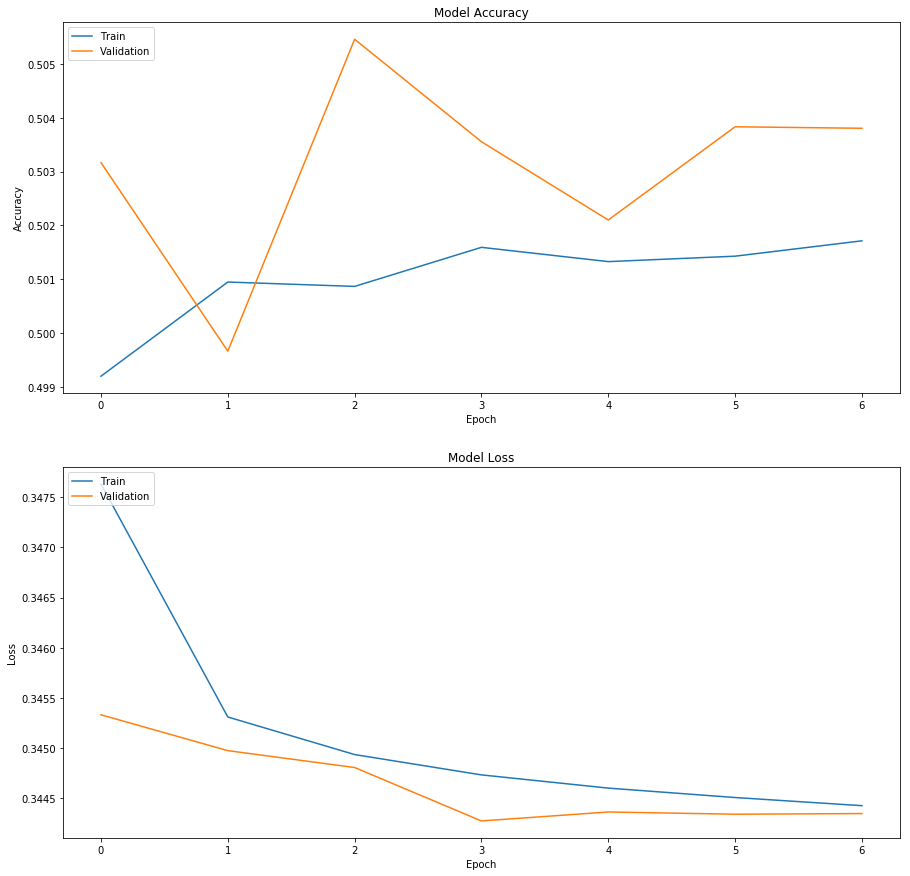

In [17]:
train_hist_plot(base_history, "model_final_base_train_perf")

In [18]:
model_base_stats = model_metrics(model_final_base, 'model_final_base', base_history, X_test_scaled, y_test)

In [19]:
model_metrics_df = model_metrics_df.append(model_base_stats, ignore_index=True)

## Model 2

In [20]:
# Instatiate a Sequential model
model_final2 = Sequential()

# Create a basic network
model_final2.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_final2.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [21]:
final2_checkpoint_path, final2_history = fit_save_model(model_final2, 'model_final2', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3496 - categorical_accuracy: 0.4990 - val_loss: 0.3457 - val_categorical_accuracy: 0.5046

Epoch 00001: val_loss improved from inf to 0.34572, saving model to model_final/model_final2.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3455 - categorical_accuracy: 0.5009 - val_loss: 0.3452 - val_categorical_accuracy: 0.5012

Epoch 00002: val_loss improved from 0.34572 to 0.34523, saving model to model_final/model_final2.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 28s 24us/step - loss: 0.3450 - categorical_accuracy: 0.5014 - val_loss: 0.3449 - val_categorical_accuracy: 0.4993

Epoch 00003: val_loss improved from 0.34523 to 0.34491, saving model to model_final/model_final2.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 28s 24us/step - loss: 0.3448 - categorical_accuracy:

In [22]:
# Load best model to save training time
model_final2 = keras.models.load_model('model_final/model_final2.hdf5')

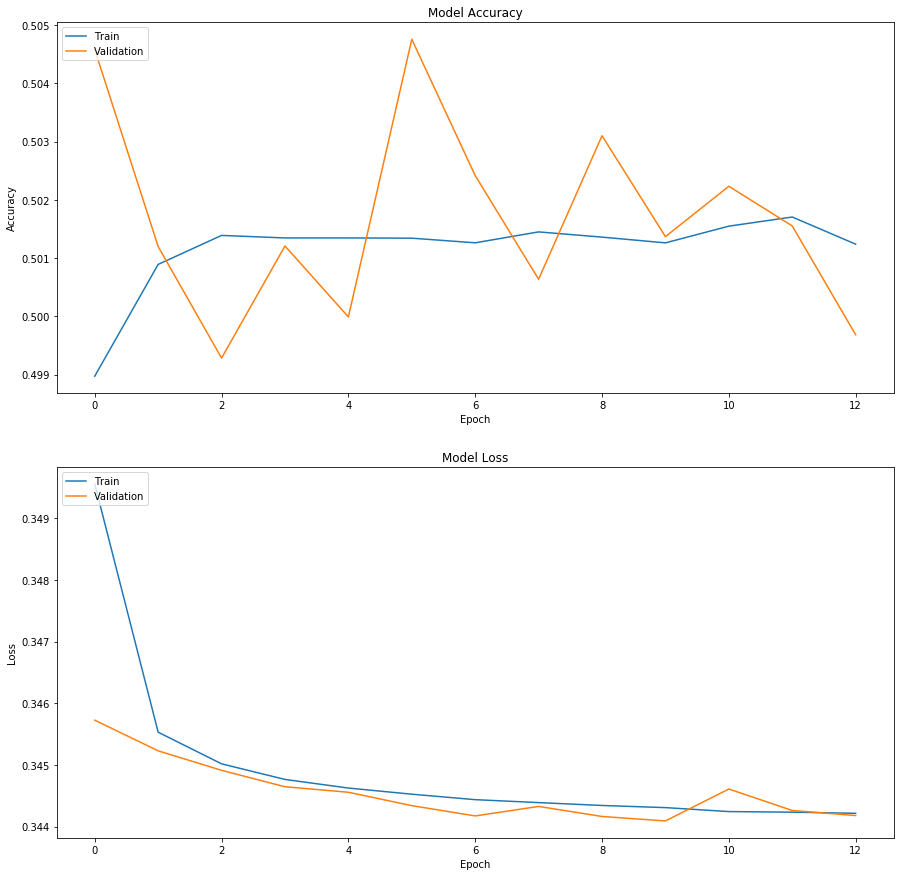

In [23]:
train_hist_plot(final2_history, "model_final2_train_perf")

In [24]:
model_final2_stats = model_metrics(model_final2, 'model_final2', final2_history, X_test_scaled, y_test)

In [25]:
model_metrics_df = model_metrics_df.append(model_final2_stats, ignore_index=True)

## Model 3

In [26]:
# Instatiate a Sequential model
model_final3 = Sequential()

# Create a basic network
model_final3.add(Dense(50, activation = 'elu', input_shape = (X_train_scaled.shape[1],)))
model_final3.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final3.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [27]:
final3_checkpoint_path, final3_history = fit_save_model(model_final3, 'model_final3', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3495 - categorical_accuracy: 0.4979 - val_loss: 0.3462 - val_categorical_accuracy: 0.4990

Epoch 00001: val_loss improved from inf to 0.34620, saving model to model_final/model_final3.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3461 - categorical_accuracy: 0.4999 - val_loss: 0.3455 - val_categorical_accuracy: 0.5030

Epoch 00002: val_loss improved from 0.34620 to 0.34552, saving model to model_final/model_final3.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3456 - categorical_accuracy: 0.5005 - val_loss: 0.3452 - val_categorical_accuracy: 0.5013

Epoch 00003: val_loss improved from 0.34552 to 0.34524, saving model to model_final/model_final3.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3454 - categorical_accuracy:

In [28]:
# Load best model to save training time
model_final3 = keras.models.load_model('model_final/model_final3.hdf5')

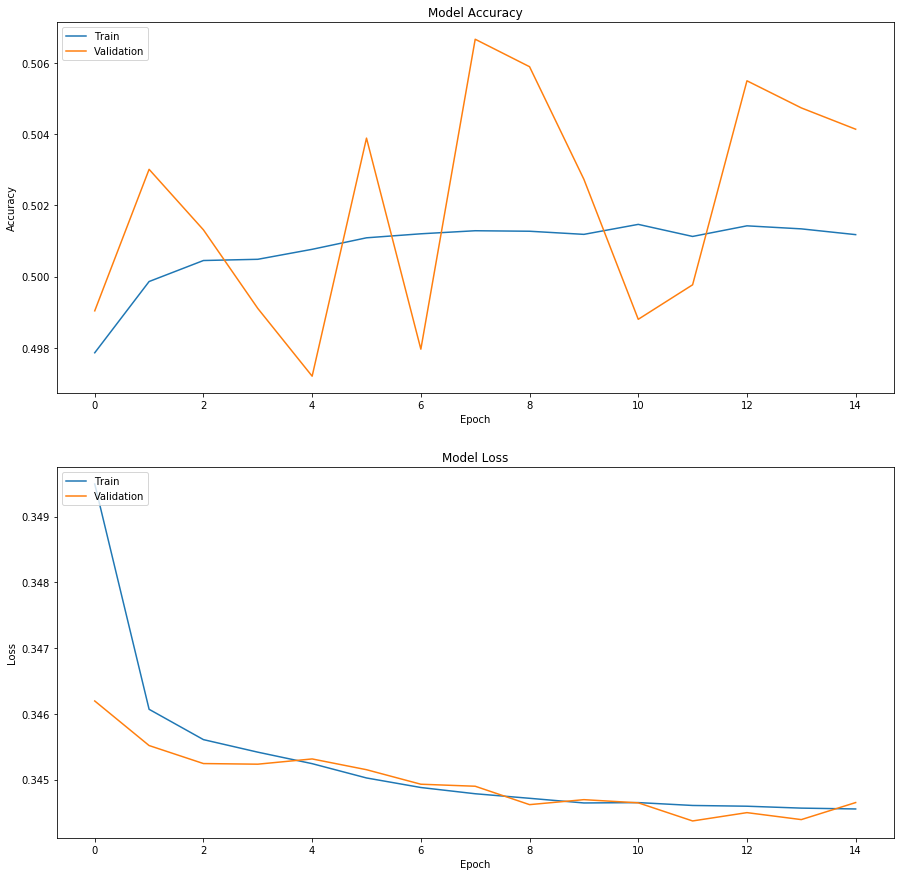

In [29]:
train_hist_plot(final3_history, "model_final3_train_perf")

In [30]:
model_final3_stats = model_metrics(model_final3, 'model_final3', final3_history, X_test_scaled, y_test)

In [31]:
model_metrics_df = model_metrics_df.append(model_final3_stats, ignore_index=True)

## Model 4

Next is to see how each activation function performs on the data in a smaller neural network by which an activation function will be determined when applying it to further models.

In [32]:
# Instatiate a Sequential model
model_final4 = Sequential()

# Create a basic network
model_final4.add(Dense(25, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final4.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final4.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [33]:
final4_checkpoint_path, final4_history = fit_save_model(model_final4, 'model_final4', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 31s 26us/step - loss: 0.3499 - categorical_accuracy: 0.4965 - val_loss: 0.3466 - val_categorical_accuracy: 0.5003

Epoch 00001: val_loss improved from inf to 0.34665, saving model to model_final/model_final4.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3462 - categorical_accuracy: 0.4994 - val_loss: 0.3456 - val_categorical_accuracy: 0.5014

Epoch 00002: val_loss improved from 0.34665 to 0.34557, saving model to model_final/model_final4.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3454 - categorical_accuracy: 0.5000 - val_loss: 0.3450 - val_categorical_accuracy: 0.5035

Epoch 00003: val_loss improved from 0.34557 to 0.34501, saving model to model_final/model_final4.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3450 - categorical_accuracy:

In [34]:
# Load best model to save training time
model_final4 = keras.models.load_model('model_final/model_final4.hdf5')

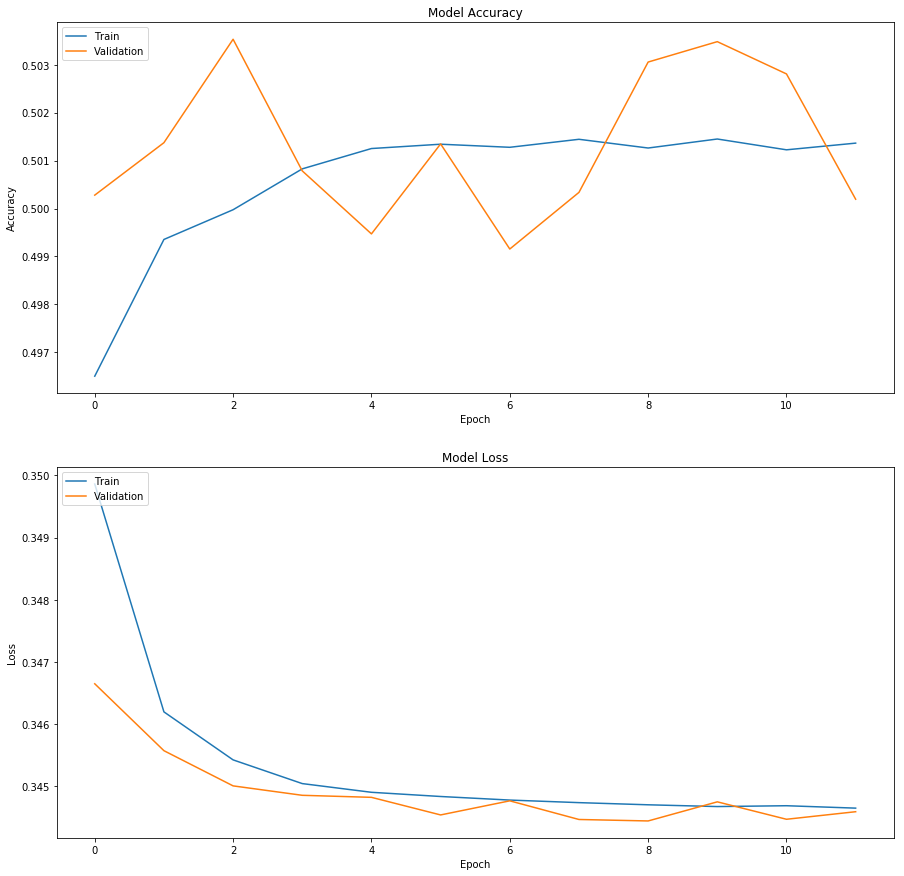

In [35]:
train_hist_plot(final4_history, "model_final4_train_perf")

In [36]:
model_final4_stats = model_metrics(model_final4, 'model_final4', final4_history, X_test_scaled, y_test)

In [37]:
model_metrics_df = model_metrics_df.append(model_final4_stats, ignore_index=True)

## Model 5

In [38]:
# Instatiate a Sequential model
model_final5 = Sequential()

# Create a basic network
model_final5.add(Dense(25, activation = 'elu', input_shape = (X_train_scaled.shape[1],)))
model_final5.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final5.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [39]:
final5_checkpoint_path, final5_history = fit_save_model(model_final5, 'model_final5', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 33s 27us/step - loss: 0.3508 - categorical_accuracy: 0.4974 - val_loss: 0.3469 - val_categorical_accuracy: 0.4979

Epoch 00001: val_loss improved from inf to 0.34685, saving model to model_final/model_final5.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 31s 26us/step - loss: 0.3464 - categorical_accuracy: 0.5002 - val_loss: 0.3460 - val_categorical_accuracy: 0.5014

Epoch 00002: val_loss improved from 0.34685 to 0.34601, saving model to model_final/model_final5.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 32s 27us/step - loss: 0.3459 - categorical_accuracy: 0.5003 - val_loss: 0.3456 - val_categorical_accuracy: 0.4993

Epoch 00003: val_loss improved from 0.34601 to 0.34562, saving model to model_final/model_final5.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 33s 27us/step - loss: 0.3457 - categorical_accuracy:

In [40]:
# Load best model to save training time
model_final5 = keras.models.load_model('model_final/model_final5.hdf5')

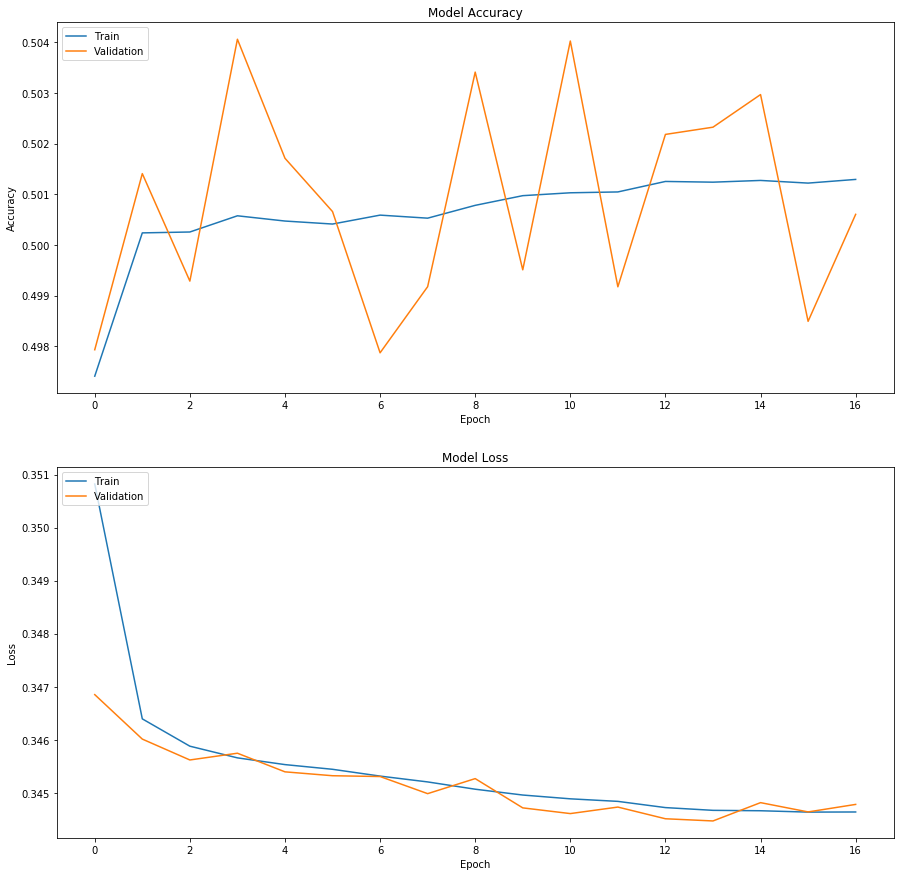

In [41]:
train_hist_plot(final5_history, "model_final5_train_perf")

In [42]:
model_final5_stats = model_metrics(model_final5, 'model_final5', final5_history, X_test_scaled, y_test)

In [43]:
model_metrics_df = model_metrics_df.append(model_final5_stats, ignore_index=True)

## Model 6

In [44]:
# Instatiate a Sequential model
model_final6 = Sequential()

# Create a basic network
model_final6.add(Dense(25, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_final6.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final6.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [45]:
final6_checkpoint_path, final6_history = fit_save_model(model_final6, 'model_final6', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 34s 29us/step - loss: 0.3508 - categorical_accuracy: 0.4970 - val_loss: 0.3465 - val_categorical_accuracy: 0.4967

Epoch 00001: val_loss improved from inf to 0.34646, saving model to model_final/model_final6.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 35s 29us/step - loss: 0.3462 - categorical_accuracy: 0.5003 - val_loss: 0.3457 - val_categorical_accuracy: 0.5008

Epoch 00002: val_loss improved from 0.34646 to 0.34573, saving model to model_final/model_final6.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 35s 29us/step - loss: 0.3456 - categorical_accuracy: 0.5007 - val_loss: 0.3455 - val_categorical_accuracy: 0.5064

Epoch 00003: val_loss improved from 0.34573 to 0.34549, saving model to model_final/model_final6.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 34s 28us/step - loss: 0.3453 - categorical_accuracy:

In [46]:
# Load best model to save training time
model_final6 = keras.models.load_model('model_final/model_final6.hdf5')

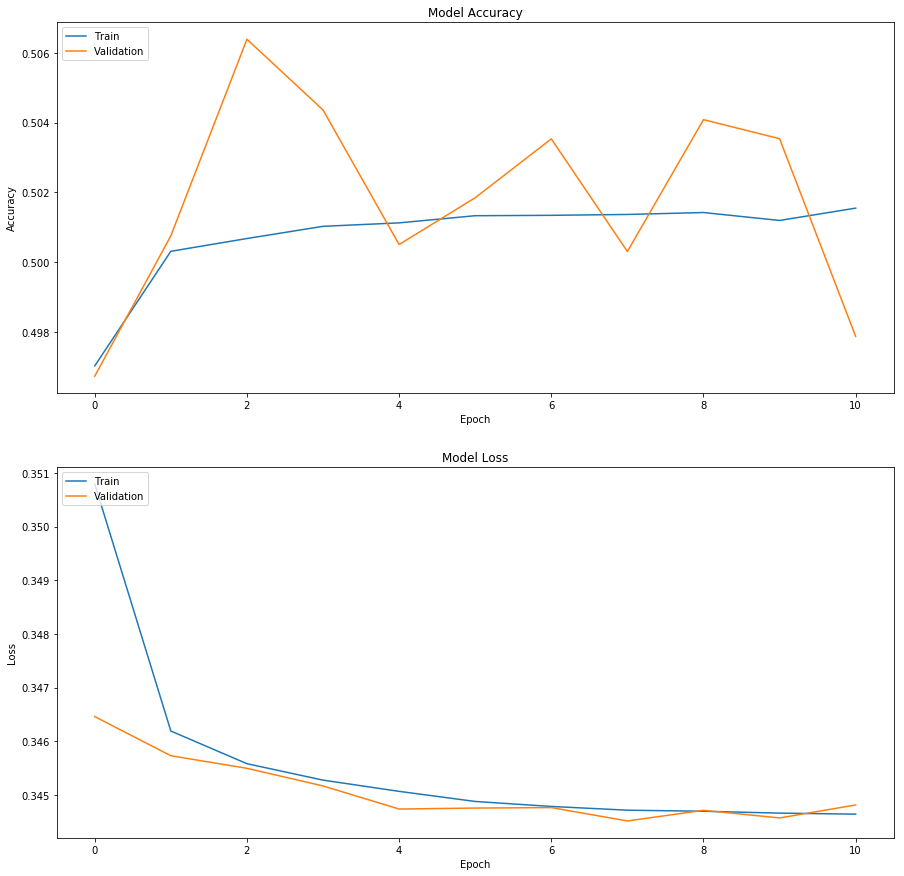

In [47]:
train_hist_plot(final6_history, "model_final6_train_perf")

In [48]:
model_final6_stats = model_metrics(model_final6, 'model_final6', final6_history, X_test_scaled, y_test)

In [49]:
model_metrics_df = model_metrics_df.append(model_final6_stats, ignore_index=True)

## Model 7

In [50]:
# Instatiate a Sequential model
model_final7 = Sequential()

# Create a basic network
model_final7.add(Dense(25, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final7.add(Dense(25, activation = 'relu'))
model_final7.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final7.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [51]:
final7_checkpoint_path, final7_history = fit_save_model(model_final7, 'model_final7', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 36s 30us/step - loss: 0.3487 - categorical_accuracy: 0.4982 - val_loss: 0.3457 - val_categorical_accuracy: 0.5010

Epoch 00001: val_loss improved from inf to 0.34567, saving model to model_final/model_final7.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 33s 28us/step - loss: 0.3452 - categorical_accuracy: 0.5006 - val_loss: 0.3447 - val_categorical_accuracy: 0.5044

Epoch 00002: val_loss improved from 0.34567 to 0.34473, saving model to model_final/model_final7.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 34s 28us/step - loss: 0.3448 - categorical_accuracy: 0.5006 - val_loss: 0.3448 - val_categorical_accuracy: 0.5059

Epoch 00003: val_loss did not improve from 0.34473
Epoch 4/50
1197789/1197789 [==============================] - 34s 28us/step - loss: 0.3446 - categorical_accuracy: 0.5010 - val_loss: 0.3452 - val_categorical_accura

In [52]:
# Load best model to save training time
model_final7 = keras.models.load_model('model_final/model_final7.hdf5')

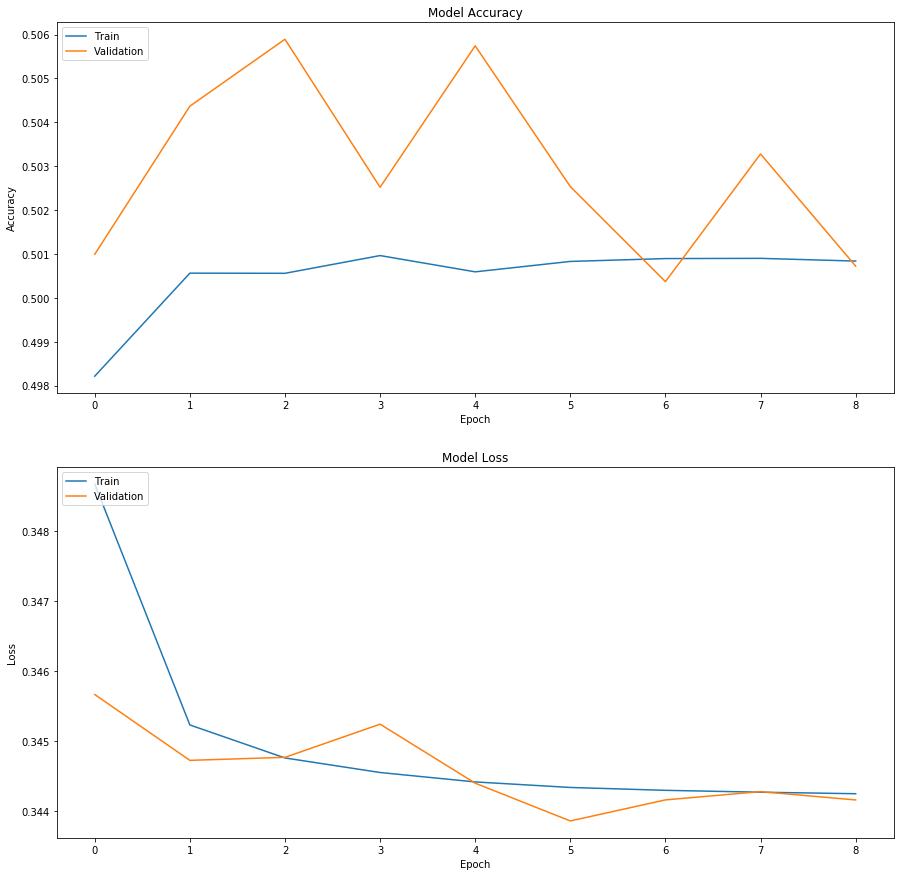

In [53]:
train_hist_plot(final7_history, "model_final7_train_perf")

In [54]:
model_final7_stats = model_metrics(model_final7, 'model_final7', final7_history, X_test_scaled, y_test)

In [55]:
model_metrics_df = model_metrics_df.append(model_final7_stats, ignore_index=True)

## Model 8

In [56]:
# Instatiate a Sequential model
model_final8 = Sequential()

# Create a basic network
model_final8.add(Dense(25, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_final8.add(Dense(50, activation = 'relu'))
model_final8.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final8.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [57]:
final8_checkpoint_path, final8_history = fit_save_model(model_final8, 'model_final8', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3479 - categorical_accuracy: 0.4980 - val_loss: 0.3452 - val_categorical_accuracy: 0.4963

Epoch 00001: val_loss improved from inf to 0.34516, saving model to model_final/model_final8.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 35s 29us/step - loss: 0.3450 - categorical_accuracy: 0.5005 - val_loss: 0.3449 - val_categorical_accuracy: 0.5024

Epoch 00002: val_loss improved from 0.34516 to 0.34489, saving model to model_final/model_final8.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 35s 30us/step - loss: 0.3446 - categorical_accuracy: 0.5007 - val_loss: 0.3445 - val_categorical_accuracy: 0.5048

Epoch 00003: val_loss improved from 0.34489 to 0.34451, saving model to model_final/model_final8.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 35s 29us/step - loss: 0.3444 - categorical_accuracy:

In [58]:
# Load best model to save training time
model_final8 = keras.models.load_model('model_final/model_final8.hdf5')

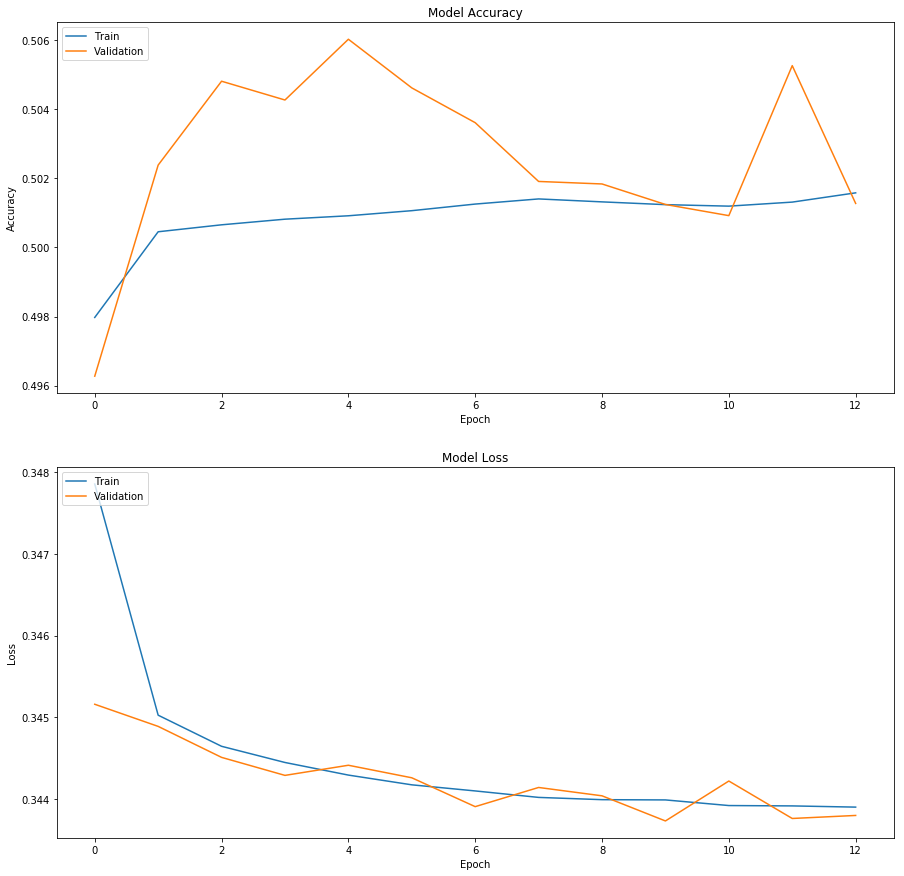

In [59]:
train_hist_plot(final8_history, "model_final8_train_perf")

In [60]:
model_final8_stats = model_metrics(model_final8, 'model_final8', final8_history, X_test_scaled, y_test)

In [61]:
model_metrics_df = model_metrics_df.append(model_final8_stats, ignore_index=True)

## Model 9

In [62]:
# Instatiate a Sequential model
model_final9 = Sequential()

# Create a basic network
model_final9.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_final9.add(Dense(25, activation = 'relu'))
model_final9.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final9.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [63]:
final9_checkpoint_path, final9_history = fit_save_model(model_final9, 'model_final9', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3484 - categorical_accuracy: 0.4977 - val_loss: 0.3454 - val_categorical_accuracy: 0.5012

Epoch 00001: val_loss improved from inf to 0.34536, saving model to model_final/model_final9.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3450 - categorical_accuracy: 0.5008 - val_loss: 0.3448 - val_categorical_accuracy: 0.4996

Epoch 00002: val_loss improved from 0.34536 to 0.34484, saving model to model_final/model_final9.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3445 - categorical_accuracy: 0.5010 - val_loss: 0.3443 - val_categorical_accuracy: 0.4987

Epoch 00003: val_loss improved from 0.34484 to 0.34430, saving model to model_final/model_final9.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 36s 30us/step - loss: 0.3443 - categorical_accuracy:

In [64]:
# Load best model to save training time
model_final9 = keras.models.load_model('model_final/model_final9.hdf5')

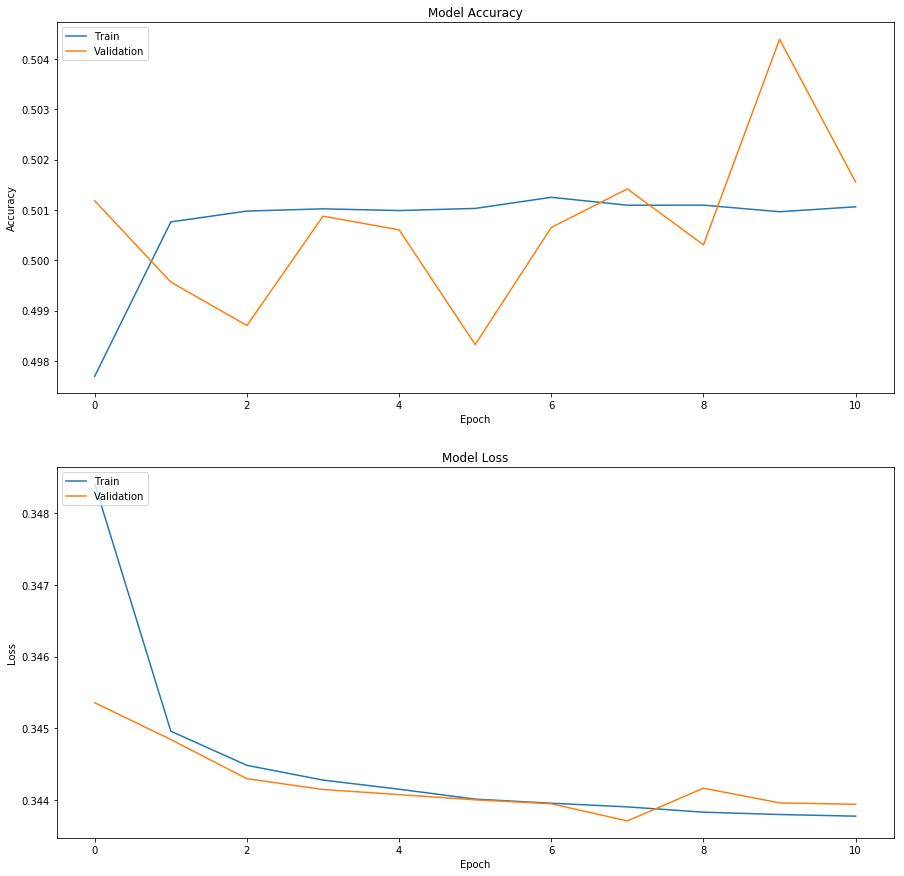

In [65]:
train_hist_plot(final9_history, "model_final9_train_perf")

In [66]:
model_final9_stats = model_metrics(model_final9, 'model_final9', final9_history, X_test_scaled, y_test)

In [67]:
model_metrics_df = model_metrics_df.append(model_final9_stats, ignore_index=True)

## Model 10

In [68]:
# Instatiate a Sequential model
model_finalX = Sequential()

# Create a basic network
model_finalX.add(Dense(25, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_finalX.add(Dense(25, activation = 'relu'))
model_finalX.add(Dense(25, activation = 'relu'))
model_finalX.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalX.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [69]:
finalX_checkpoint_path, finalX_history = fit_save_model(model_finalX, 'model_finalX', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 38s 32us/step - loss: 0.3483 - categorical_accuracy: 0.4981 - val_loss: 0.3456 - val_categorical_accuracy: 0.5012

Epoch 00001: val_loss improved from inf to 0.34556, saving model to model_final/model_finalX.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3453 - categorical_accuracy: 0.5005 - val_loss: 0.3448 - val_categorical_accuracy: 0.5047

Epoch 00002: val_loss improved from 0.34556 to 0.34478, saving model to model_final/model_finalX.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3449 - categorical_accuracy: 0.5005 - val_loss: 0.3445 - val_categorical_accuracy: 0.5009

Epoch 00003: val_loss improved from 0.34478 to 0.34449, saving model to model_final/model_finalX.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3447 - categorical_accuracy:

In [70]:
# Load best model to save training time
model_finalX = keras.models.load_model('model_final/model_finalX.hdf5')

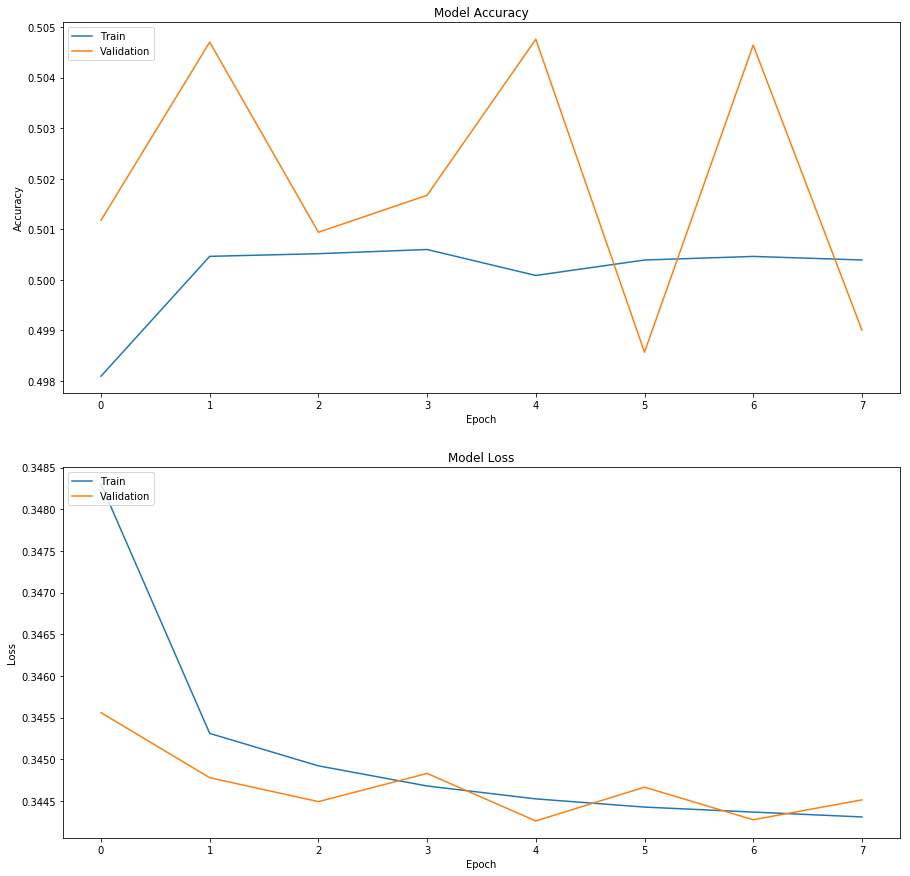

In [71]:
train_hist_plot(finalX_history, "model_finalX_train_perf")

In [72]:
model_finalX_stats = model_metrics(model_finalX, 'model_finalX', finalX_history, X_test_scaled, y_test)

In [73]:
model_metrics_df = model_metrics_df.append(model_finalX_stats, ignore_index=True)

## Model 11

In [74]:
# Instatiate a Sequential model
model_finalXI = Sequential()

# Create a basic network
model_finalXI.add(Dense(25, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_finalXI.add(Dense(25, activation = 'tanh'))
model_finalXI.add(Dense(25, activation = 'tanh'))
model_finalXI.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXI.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [75]:
finalXI_checkpoint_path, finalXI_history = fit_save_model(model_finalXI, 'model_finalXI', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 38s 31us/step - loss: 0.3486 - categorical_accuracy: 0.4976 - val_loss: 0.3454 - val_categorical_accuracy: 0.5067

Epoch 00001: val_loss improved from inf to 0.34544, saving model to model_final/model_finalXI.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 36s 30us/step - loss: 0.3451 - categorical_accuracy: 0.5002 - val_loss: 0.3446 - val_categorical_accuracy: 0.5008

Epoch 00002: val_loss improved from 0.34544 to 0.34458, saving model to model_final/model_finalXI.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3447 - categorical_accuracy: 0.5005 - val_loss: 0.3445 - val_categorical_accuracy: 0.5000

Epoch 00003: val_loss improved from 0.34458 to 0.34451, saving model to model_final/model_finalXI.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3445 - categorical_accura

In [76]:
# Load best model to save training time
model_finalXI = keras.models.load_model('model_final/model_finalXI.hdf5')

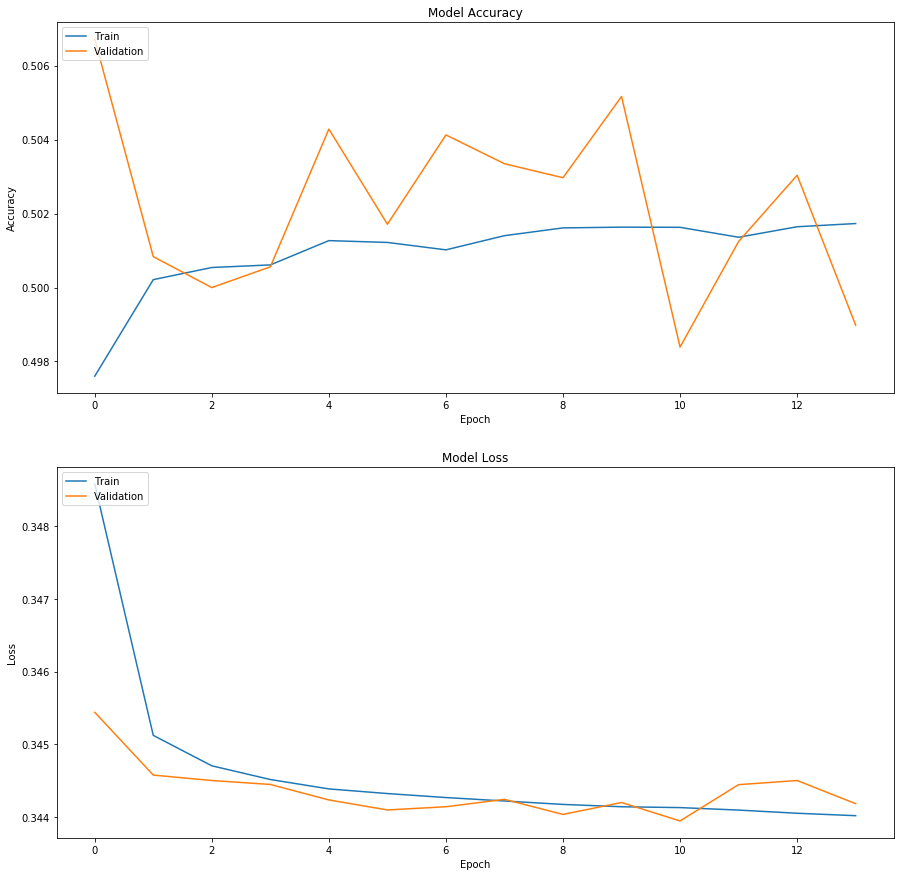

In [77]:
train_hist_plot(finalXI_history, "model_finalXI_train_perf")

In [78]:
model_finalXI_stats = model_metrics(model_finalXI, 'model_finalXI', finalXI_history, X_test_scaled, y_test)

In [79]:
model_metrics_df = model_metrics_df.append(model_finalXI_stats, ignore_index=True)

## Model 12

In [80]:
# Instatiate a Sequential model
model_finalXII = Sequential()

# Create a basic network
model_finalXII.add(Dense(25, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_finalXII.add(Dense(25, activation = 'relu'))
model_finalXII.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXII.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [81]:
finalXII_checkpoint_path, finalXII_history = fit_save_model(model_finalXII, 'model_finalXII', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3487 - categorical_accuracy: 0.4978 - val_loss: 0.3461 - val_categorical_accuracy: 0.4989

Epoch 00001: val_loss improved from inf to 0.34611, saving model to model_final/model_finalXII.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 36s 30us/step - loss: 0.3460 - categorical_accuracy: 0.5002 - val_loss: 0.3451 - val_categorical_accuracy: 0.5030

Epoch 00002: val_loss improved from 0.34611 to 0.34512, saving model to model_final/model_finalXII.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 36s 30us/step - loss: 0.3451 - categorical_accuracy: 0.5004 - val_loss: 0.3448 - val_categorical_accuracy: 0.5023

Epoch 00003: val_loss improved from 0.34512 to 0.34484, saving model to model_final/model_finalXII.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 36s 30us/step - loss: 0.3447 - categorical_acc

In [82]:
# Load best model to save training time
model_finalXII = keras.models.load_model('model_final/model_finalXII.hdf5')

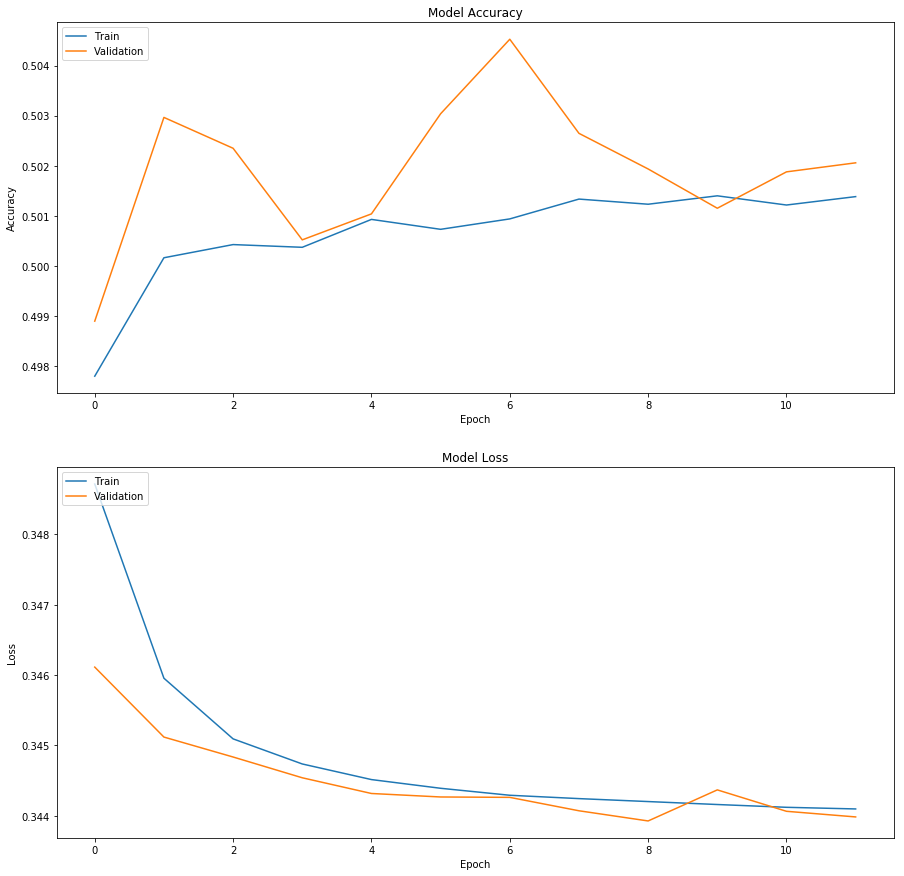

In [83]:
train_hist_plot(finalXII_history, "model_finalXII_train_perf")

In [84]:
model_finalXII_stats = model_metrics(model_finalXII, 'model_finalXII', finalXII_history, X_test_scaled, y_test)

In [85]:
model_metrics_df = model_metrics_df.append(model_finalXII_stats, ignore_index=True)

## Model 13

In [86]:
# Instatiate a Sequential model
model_finalXIII = Sequential()

# Create a basic network
model_finalXIII.add(Dense(25, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_finalXIII.add(Dense(25, activation = 'tanh'))
model_finalXIII.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXIII.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [87]:
finalXIII_checkpoint_path, finalXIII_history = fit_save_model(model_finalXIII, 'model_finalXIII', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 38s 32us/step - loss: 0.3481 - categorical_accuracy: 0.4969 - val_loss: 0.3455 - val_categorical_accuracy: 0.5033

Epoch 00001: val_loss improved from inf to 0.34553, saving model to model_final/model_finalXIII.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3451 - categorical_accuracy: 0.4993 - val_loss: 0.3448 - val_categorical_accuracy: 0.4970

Epoch 00002: val_loss improved from 0.34553 to 0.34478, saving model to model_final/model_finalXIII.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3448 - categorical_accuracy: 0.4995 - val_loss: 0.3447 - val_categorical_accuracy: 0.5028

Epoch 00003: val_loss improved from 0.34478 to 0.34469, saving model to model_final/model_finalXIII.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 38s 31us/step - loss: 0.3447 - categorical_

In [88]:
# Load best model to save training time
model_finalXIII = keras.models.load_model('model_final/model_finalXIII.hdf5')

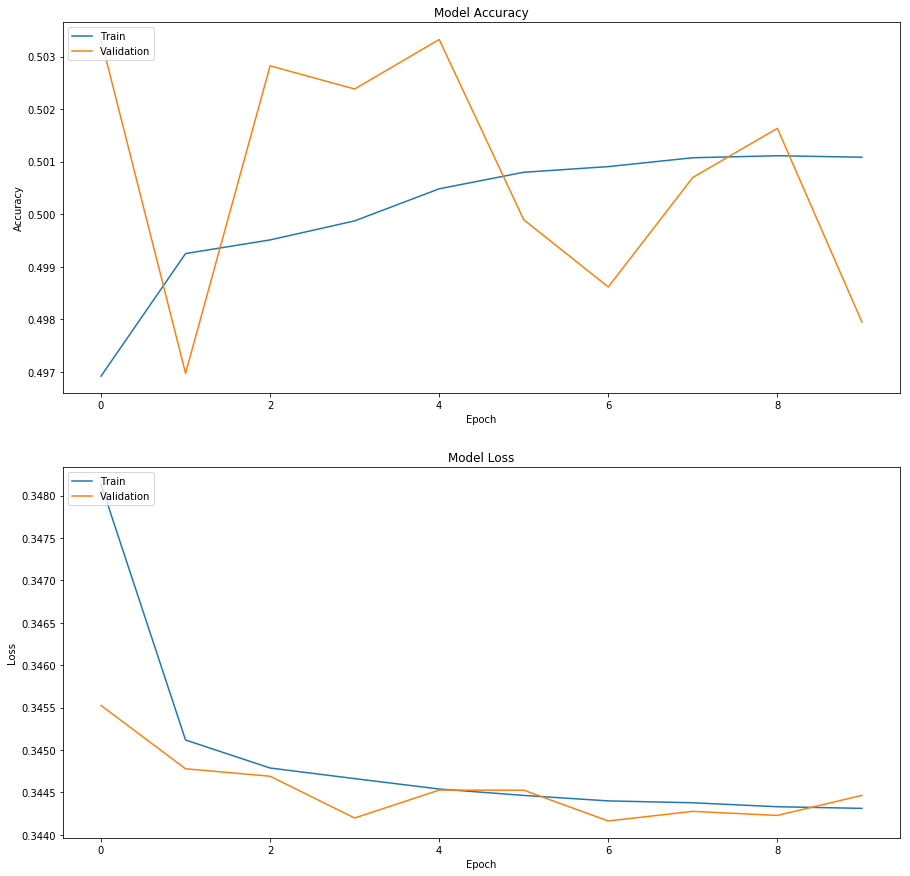

In [89]:
train_hist_plot(finalXIII_history, "model_finalXIII_train_perf")

In [90]:
model_finalXIII_stats = model_metrics(model_finalXIII, 'model_finalXIII', finalXII_history, X_test_scaled, y_test)

In [91]:
model_metrics_df = model_metrics_df.append(model_finalXIII_stats, ignore_index=True)

## Model 14

In [92]:
# Instatiate a Sequential model
model_finalXIV = Sequential()

# Create a basic network
model_finalXIV.add(Dense(25, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_finalXIV.add(Dense(25, activation = 'tanh'))
model_finalXIV.add(Dense(25, activation = 'relu'))
model_finalXIV.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXIV.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [93]:
finalXIV_checkpoint_path, finalXIV_history = fit_save_model(model_finalXIV, 'model_finalXIV', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 40s 34us/step - loss: 0.3488 - categorical_accuracy: 0.4966 - val_loss: 0.3454 - val_categorical_accuracy: 0.5009

Epoch 00001: val_loss improved from inf to 0.34537, saving model to model_final/model_finalXIV.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 39s 33us/step - loss: 0.3453 - categorical_accuracy: 0.5009 - val_loss: 0.3447 - val_categorical_accuracy: 0.4981

Epoch 00002: val_loss improved from 0.34537 to 0.34466, saving model to model_final/model_finalXIV.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 39s 33us/step - loss: 0.3446 - categorical_accuracy: 0.5011 - val_loss: 0.3445 - val_categorical_accuracy: 0.5023

Epoch 00003: val_loss improved from 0.34466 to 0.34446, saving model to model_final/model_finalXIV.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 39s 33us/step - loss: 0.3444 - categorical_acc

In [94]:
# Load best model to save training time
model_finalXIV = keras.models.load_model('model_final/model_finalXIV.hdf5')

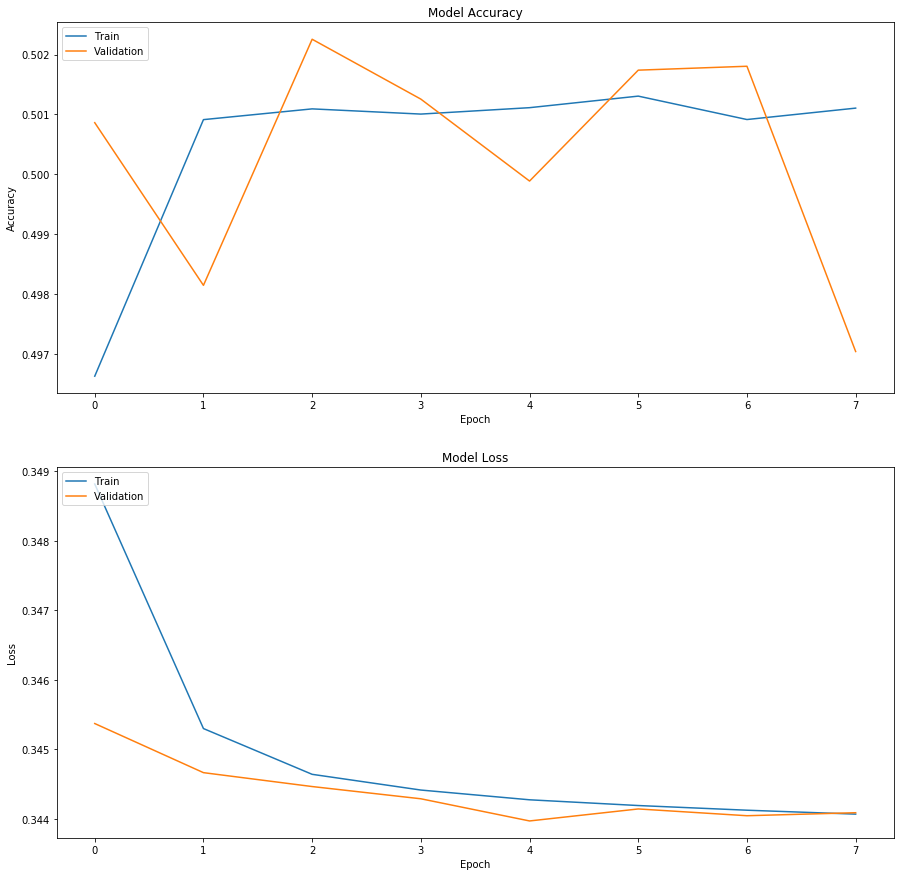

In [95]:
train_hist_plot(finalXIV_history, "model_finalXIV_train_perf")

In [96]:
model_finalXIV_stats = model_metrics(model_finalXIV, 'model_finalXIV', finalXIV_history, X_test_scaled, y_test)

In [97]:
model_metrics_df = model_metrics_df.append(model_finalXIV_stats, ignore_index=True)

## Model 15

In [98]:
# Instatiate a Sequential model
model_finalXV = Sequential()

# Create a basic network
model_finalXV.add(Dense(25, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_finalXV.add(Dense(25, activation = 'tanh'))
model_finalXV.add(Dense(25, activation = 'relu'))
model_finalXV.add(Dense(25, activation = 'relu'))
model_finalXV.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXV.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [99]:
finalXV_checkpoint_path, finalXV_history = fit_save_model(model_finalXV, 'model_finalXV', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 44s 37us/step - loss: 0.3483 - categorical_accuracy: 0.4973 - val_loss: 0.3457 - val_categorical_accuracy: 0.4976

Epoch 00001: val_loss improved from inf to 0.34571, saving model to model_final/model_finalXV.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 42s 35us/step - loss: 0.3453 - categorical_accuracy: 0.5004 - val_loss: 0.3445 - val_categorical_accuracy: 0.5018

Epoch 00002: val_loss improved from 0.34571 to 0.34449, saving model to model_final/model_finalXV.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 43s 36us/step - loss: 0.3448 - categorical_accuracy: 0.5007 - val_loss: 0.3448 - val_categorical_accuracy: 0.5044

Epoch 00003: val_loss did not improve from 0.34449
Epoch 4/50
1197789/1197789 [==============================] - 42s 35us/step - loss: 0.3446 - categorical_accuracy: 0.5010 - val_loss: 0.3446 - val_categorical_accu

In [100]:
# Load best model to save training time
model_finalXV = keras.models.load_model('model_final/model_finalXV.hdf5')

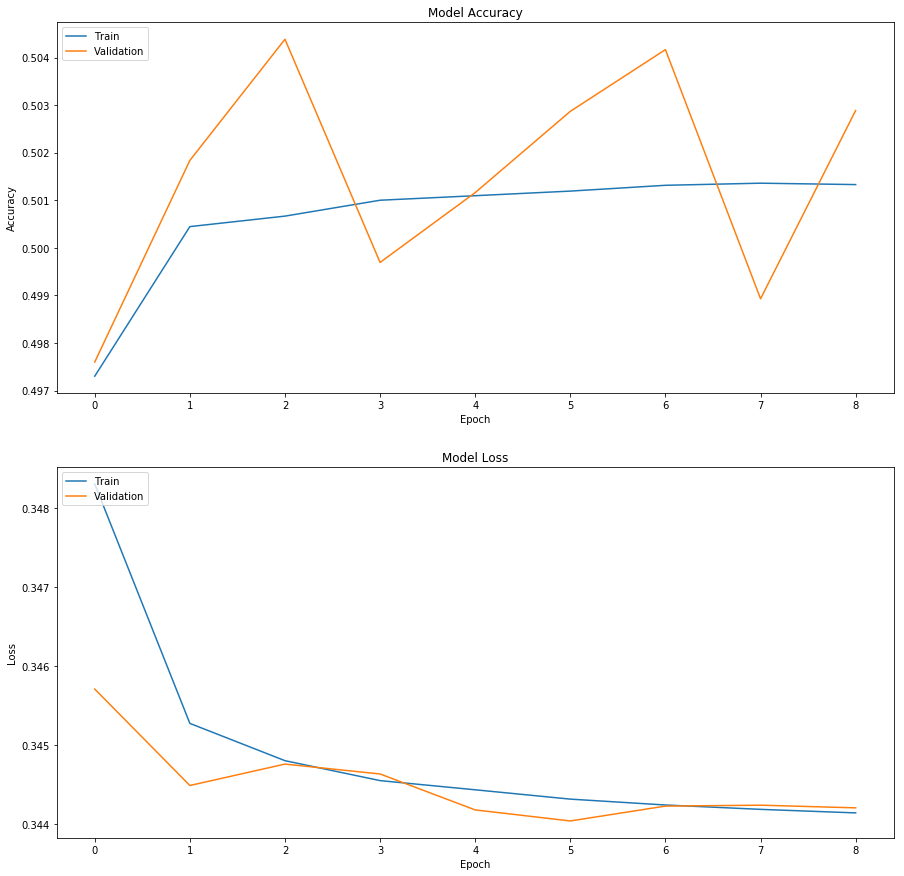

In [101]:
train_hist_plot(finalXV_history, "model_finalXV_train_perf")

In [102]:
model_finalXV_stats = model_metrics(model_finalXV, 'model_finalXV', finalXV_history, X_test_scaled, y_test)

In [103]:
model_metrics_df = model_metrics_df.append(model_finalXV_stats, ignore_index=True)

## Model 16

In [104]:
# Instatiate a Sequential model
model_finalXVI = Sequential()

# Create a basic network
model_finalXVI.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_finalXVI.add(Dense(25, activation = 'tanh'))
model_finalXVI.add(Dense(25, activation = 'relu'))
model_finalXVI.add(Dense(25, activation = 'relu'))
model_finalXVI.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXVI.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [105]:
finalXVI_checkpoint_path, finalXVI_history = fit_save_model(model_finalXVI, 'model_finalXVI', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 47s 39us/step - loss: 0.3481 - categorical_accuracy: 0.4975 - val_loss: 0.3453 - val_categorical_accuracy: 0.5027

Epoch 00001: val_loss improved from inf to 0.34532, saving model to model_final/model_finalXVI.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 45s 38us/step - loss: 0.3452 - categorical_accuracy: 0.5002 - val_loss: 0.3455 - val_categorical_accuracy: 0.4993

Epoch 00002: val_loss did not improve from 0.34532
Epoch 3/50
1197789/1197789 [==============================] - 45s 38us/step - loss: 0.3447 - categorical_accuracy: 0.5010 - val_loss: 0.3450 - val_categorical_accuracy: 0.4978

Epoch 00003: val_loss improved from 0.34532 to 0.34502, saving model to model_final/model_finalXVI.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 45s 38us/step - loss: 0.3445 - categorical_accuracy: 0.5013 - val_loss: 0.3450 - val_categorical_ac

In [106]:
# Load best model to save training time
model_finalXVI = keras.models.load_model('model_final/model_finalXVI.hdf5')

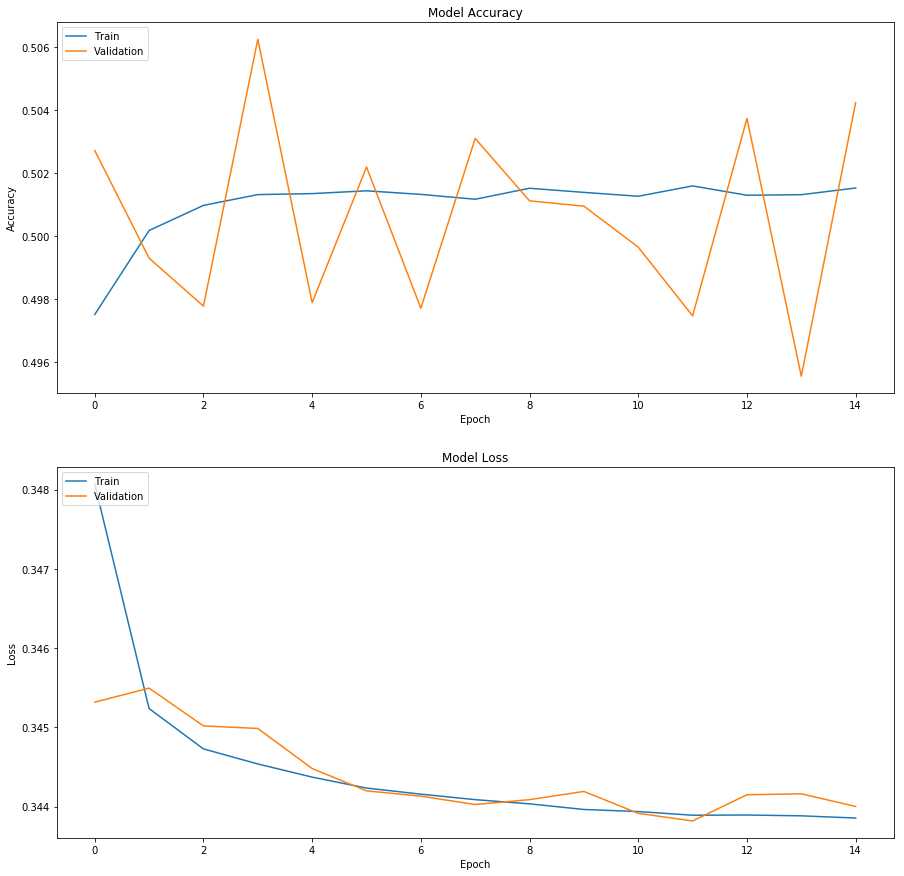

In [107]:
train_hist_plot(finalXVI_history, "model_finalXVI_train_perf")

In [108]:
model_finalXVI_stats = model_metrics(model_finalXVI, 'model_finalXVI', finalXVI_history, X_test_scaled, y_test)

In [109]:
model_metrics_df = model_metrics_df.append(model_finalXVI_stats, ignore_index=True)

## Model 17

In [110]:
# Instatiate a Sequential model
model_finalXVII = Sequential()

# Create a basic network
model_finalXVII.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_finalXVII.add(Dense(25, activation = 'relu'))
model_finalXVII.add(Dense(25, activation = 'relu'))
model_finalXVII.add(Dense(6, activation = 'relu'))
model_finalXVII.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXVII.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [111]:
finalXVII_checkpoint_path, finalXVII_history = fit_save_model(model_finalXVII, 'model_finalXVII', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 49s 41us/step - loss: 0.3519 - categorical_accuracy: 0.4876 - val_loss: 0.3470 - val_categorical_accuracy: 0.4950

Epoch 00001: val_loss improved from inf to 0.34701, saving model to model_final/model_finalXVII.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 47s 39us/step - loss: 0.3461 - categorical_accuracy: 0.4957 - val_loss: 0.3459 - val_categorical_accuracy: 0.4937

Epoch 00002: val_loss improved from 0.34701 to 0.34588, saving model to model_final/model_finalXVII.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 47s 39us/step - loss: 0.3457 - categorical_accuracy: 0.4961 - val_loss: 0.3457 - val_categorical_accuracy: 0.4941

Epoch 00003: val_loss improved from 0.34588 to 0.34571, saving model to model_final/model_finalXVII.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 47s 39us/step - loss: 0.3454 - categorical_

In [112]:
# Load best model to save training time
model_finalXVII = keras.models.load_model('model_final/model_finalXVII.hdf5')

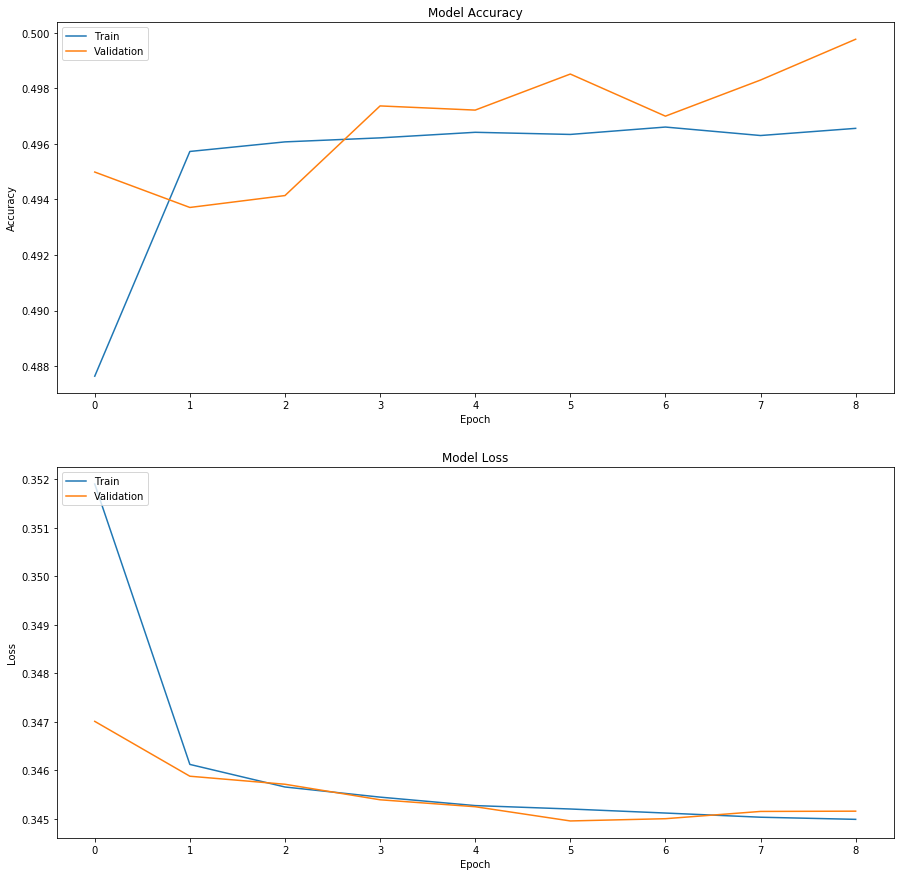

In [113]:
train_hist_plot(finalXVII_history, "model_finalXVII_train_perf")

In [114]:
model_finalXVII_stats = model_metrics(model_finalXVII, 'model_finalXVII', finalXVII_history, X_test_scaled, y_test)

In [115]:
model_metrics_df = model_metrics_df.append(model_finalXVII_stats, ignore_index=True)

## Model 18

In [116]:
# Instatiate a Sequential model
model_finalXVIII = Sequential()

# Create a basic network
model_finalXVIII.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_finalXVIII.add(Dense(25, activation = 'relu'))
model_finalXVIII.add(Dense(25, activation = 'relu'))
model_finalXVIII.add(Dense(25, activation = 'relu'))
model_finalXVIII.add(Dense(8, activation = 'relu'))
model_finalXVIII.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXVIII.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [117]:
finalXVIII_checkpoint_path, finalXVIII_history = fit_save_model(model_finalXVIII, 'model_finalXVIII', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 52s 43us/step - loss: 0.3521 - categorical_accuracy: 0.4901 - val_loss: 0.3461 - val_categorical_accuracy: 0.5007

Epoch 00001: val_loss improved from inf to 0.34613, saving model to model_final/model_finalXVIII.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 50s 42us/step - loss: 0.3463 - categorical_accuracy: 0.4956 - val_loss: 0.3457 - val_categorical_accuracy: 0.4977

Epoch 00002: val_loss improved from 0.34613 to 0.34567, saving model to model_final/model_finalXVIII.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 50s 42us/step - loss: 0.3458 - categorical_accuracy: 0.4964 - val_loss: 0.3460 - val_categorical_accuracy: 0.4974

Epoch 00003: val_loss did not improve from 0.34567
Epoch 4/50
1197789/1197789 [==============================] - 50s 42us/step - loss: 0.3456 - categorical_accuracy: 0.4966 - val_loss: 0.3451 - val_categorica

In [118]:
# Load best model to save training time
model_finalXVIII = keras.models.load_model('model_final/model_finalXVIII.hdf5')

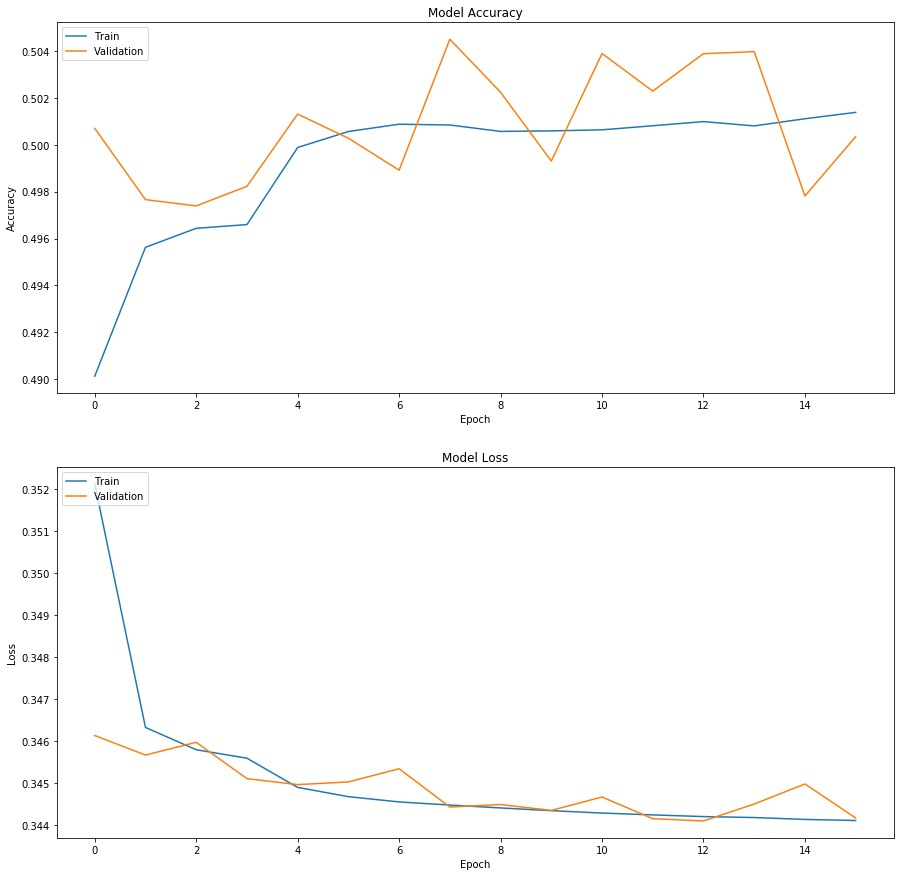

In [119]:
train_hist_plot(finalXVIII_history, "model_finalXVIII_train_perf")

In [120]:
model_finalXVIII_stats = model_metrics(model_finalXVIII, 'model_finalXVIII', finalXVIII_history, X_test_scaled, y_test)

In [121]:
model_metrics_df = model_metrics_df.append(model_finalXVIII_stats, ignore_index=True)

## Model 19

In [122]:
# Instatiate a Sequential model
model_finalXIX = Sequential()

# Create a basic network
model_finalXIX.add(Dense(25, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_finalXIX.add(Dense(25, activation = 'relu'))
model_finalXIX.add(Dense(25, activation = 'relu'))
model_finalXIX.add(Dense(25, activation = 'relu'))
model_finalXIX.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXIX.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [123]:
finalXIX_checkpoint_path, finalXIX_history = fit_save_model(model_finalXIX, 'model_finalXIX', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 53s 44us/step - loss: 0.3486 - categorical_accuracy: 0.4974 - val_loss: 0.3455 - val_categorical_accuracy: 0.4967

Epoch 00001: val_loss improved from inf to 0.34548, saving model to model_final/model_finalXIX.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 51s 43us/step - loss: 0.3454 - categorical_accuracy: 0.5004 - val_loss: 0.3456 - val_categorical_accuracy: 0.4983

Epoch 00002: val_loss did not improve from 0.34548
Epoch 3/50
1197789/1197789 [==============================] - 51s 42us/step - loss: 0.3449 - categorical_accuracy: 0.5004 - val_loss: 0.3449 - val_categorical_accuracy: 0.5008

Epoch 00003: val_loss improved from 0.34548 to 0.34488, saving model to model_final/model_finalXIX.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 51s 42us/step - loss: 0.3447 - categorical_accuracy: 0.5004 - val_loss: 0.3446 - val_categorical_ac

In [124]:
# Load best model to save training time
model_finalXIX = keras.models.load_model('model_final/model_finalXIX.hdf5')

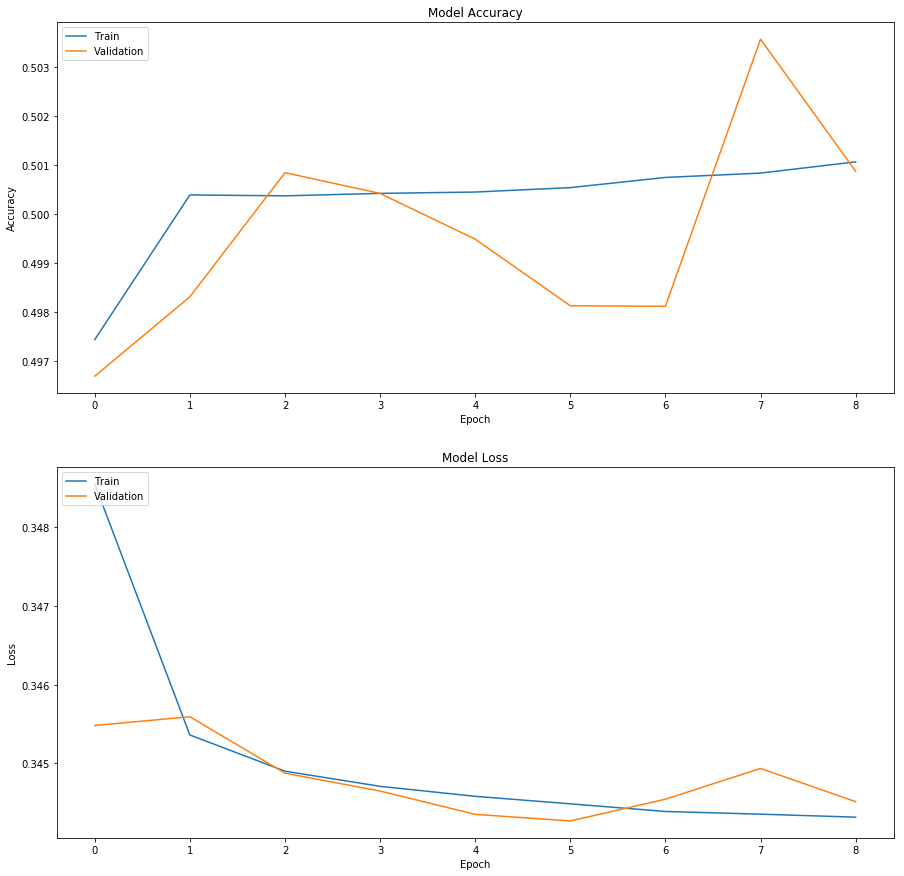

In [125]:
train_hist_plot(finalXIX_history, "model_finalXIX_train_perf")

In [126]:
model_finalXIX_stats = model_metrics(model_finalXIX, 'model_finalXIX', finalXIX_history, X_test_scaled, y_test)

In [127]:
model_metrics_df = model_metrics_df.append(model_finalXIX_stats, ignore_index=True)

## Model 20

In [128]:
# Instatiate a Sequential model
model_finalXX = Sequential()

# Create a basic network
model_finalXX.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_finalXX.add(Dense(25, activation = 'relu'))
model_finalXX.add(Dense(25, activation = 'relu'))
model_finalXX.add(Dense(25, activation = 'relu'))
model_finalXX.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXX.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [129]:
finalXX_checkpoint_path, finalXX_history = fit_save_model(model_finalXX, 'model_finalXX', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 61s 51us/step - loss: 0.3478 - categorical_accuracy: 0.4974 - val_loss: 0.3452 - val_categorical_accuracy: 0.4955

Epoch 00001: val_loss improved from inf to 0.34522, saving model to model_final/model_finalXX.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 67s 56us/step - loss: 0.3451 - categorical_accuracy: 0.4996 - val_loss: 0.3449 - val_categorical_accuracy: 0.5031

Epoch 00002: val_loss improved from 0.34522 to 0.34493, saving model to model_final/model_finalXX.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 61s 51us/step - loss: 0.3447 - categorical_accuracy: 0.5007 - val_loss: 0.3443 - val_categorical_accuracy: 0.5045

Epoch 00003: val_loss improved from 0.34493 to 0.34434, saving model to model_final/model_finalXX.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 55s 46us/step - loss: 0.3445 - categorical_accura

In [130]:
# Load best model to save training time
model_finalXX = keras.models.load_model('model_final/model_finalXX.hdf5')

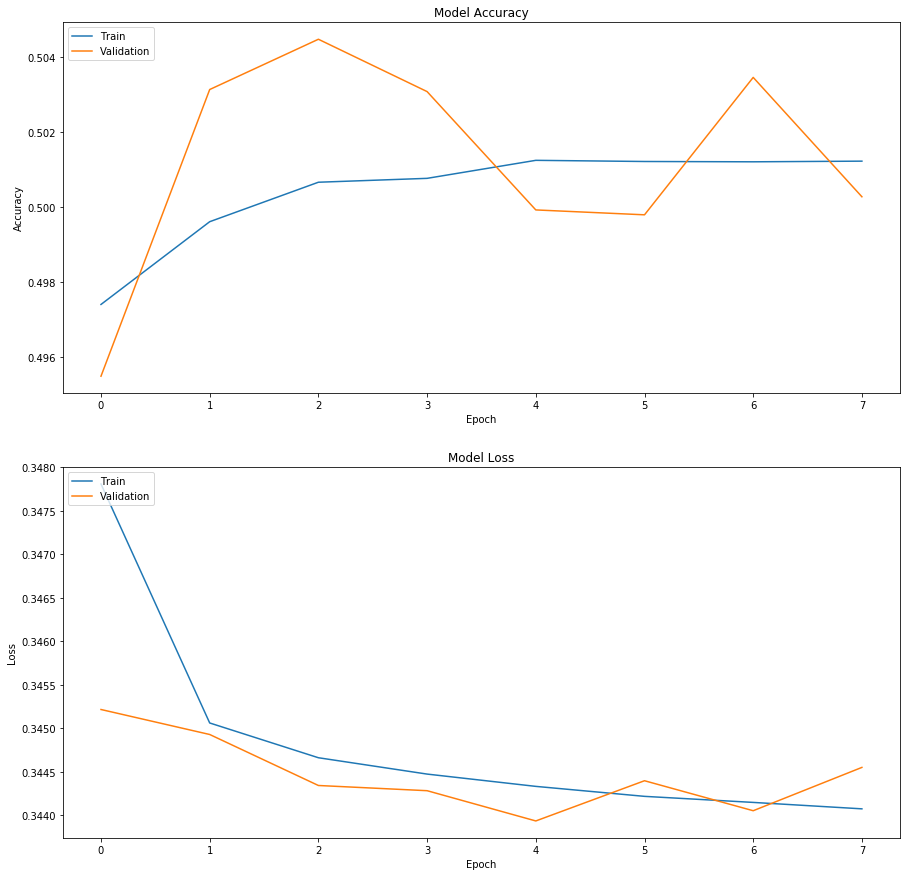

In [131]:
train_hist_plot(finalXX_history, "model_finalXX_train_perf")

In [132]:
model_finalXX_stats = model_metrics(model_finalXX, 'model_finalXX', finalXX_history, X_test_scaled, y_test)

In [133]:
model_metrics_df = model_metrics_df.append(model_finalXX_stats, ignore_index=True)

## Model 21

In [134]:
# Instatiate a Sequential model
model_finalXXI = Sequential()

# Create a basic network
model_finalXXI.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_finalXXI.add(Dense(50, activation = 'tanh'))
model_finalXXI.add(Dense(25, activation = 'relu'))
model_finalXXI.add(Dense(25, activation = 'relu'))
model_finalXXI.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXXI.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [135]:
finalXXI_checkpoint_path, finalXXI_history = fit_save_model(model_finalXXI, 'model_finalXXI', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 60s 50us/step - loss: 0.3478 - categorical_accuracy: 0.4978 - val_loss: 0.3452 - val_categorical_accuracy: 0.4962

Epoch 00001: val_loss improved from inf to 0.34522, saving model to model_final/model_finalXXI.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 58s 48us/step - loss: 0.3451 - categorical_accuracy: 0.5002 - val_loss: 0.3454 - val_categorical_accuracy: 0.4988

Epoch 00002: val_loss did not improve from 0.34522
Epoch 3/50
1197789/1197789 [==============================] - 58s 48us/step - loss: 0.3447 - categorical_accuracy: 0.5003 - val_loss: 0.3444 - val_categorical_accuracy: 0.5025

Epoch 00003: val_loss improved from 0.34522 to 0.34438, saving model to model_final/model_finalXXI.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 58s 48us/step - loss: 0.3445 - categorical_accuracy: 0.5010 - val_loss: 0.3444 - val_categorical_ac

In [136]:
# Load best model to save training time
model_finalXXI = keras.models.load_model('model_final/model_finalXXI.hdf5')

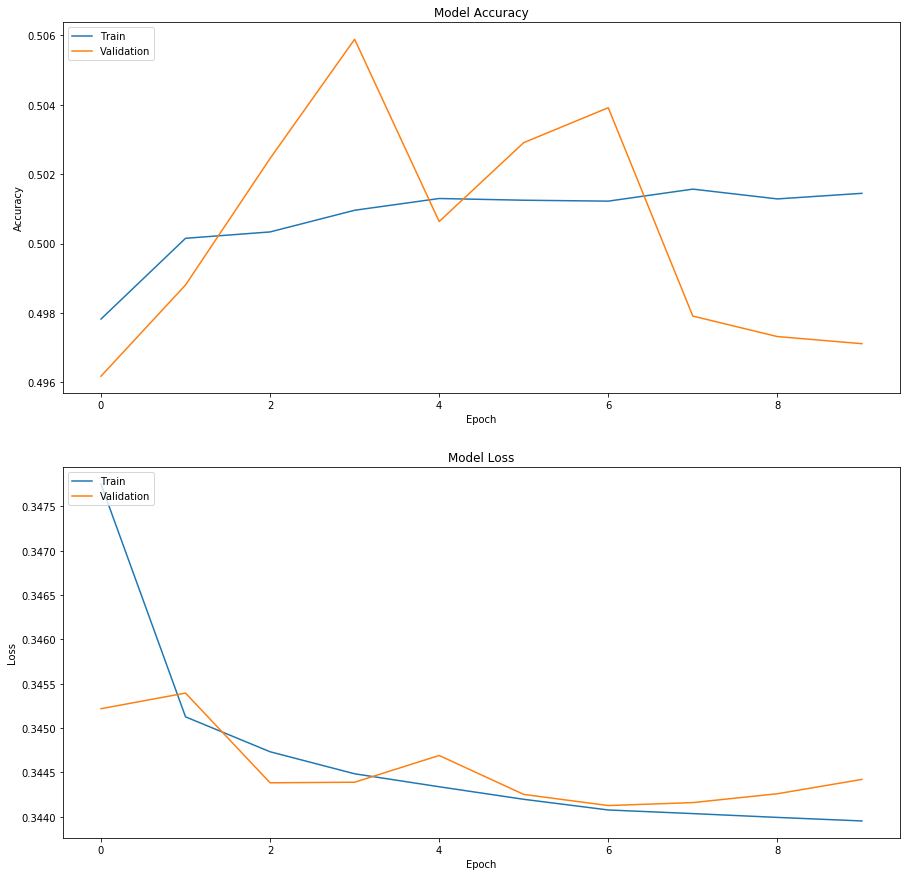

In [137]:
train_hist_plot(finalXXI_history, "model_finalXXI_train_perf")

In [138]:
model_finalXXI_stats = model_metrics(model_finalXXI, 'model_finalXXI', finalXXI_history, X_test_scaled, y_test)

In [139]:
model_metrics_df = model_metrics_df.append(model_finalXXI_stats, ignore_index=True)

## Model 22

In [140]:
# Instatiate a Sequential model
model_finalXXII = Sequential()

# Create a basic network
model_finalXXII.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_finalXXII.add(Dense(50, activation = 'tanh'))
model_finalXXII.add(Dense(25, activation = 'relu'))
model_finalXXII.add(Dense(25, activation = 'relu'))
model_finalXXII.add(Dense(25, activation = 'relu'))
model_finalXXII.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXXII.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [141]:
finalXXII_checkpoint_path, finalXXII_history = fit_save_model(model_finalXXII, 'model_finalXXII', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 64s 53us/step - loss: 0.3480 - categorical_accuracy: 0.4976 - val_loss: 0.3460 - val_categorical_accuracy: 0.5022

Epoch 00001: val_loss improved from inf to 0.34603, saving model to model_final/model_finalXXII.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 63s 52us/step - loss: 0.3453 - categorical_accuracy: 0.5003 - val_loss: 0.3446 - val_categorical_accuracy: 0.5023

Epoch 00002: val_loss improved from 0.34603 to 0.34458, saving model to model_final/model_finalXXII.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 62s 52us/step - loss: 0.3448 - categorical_accuracy: 0.5004 - val_loss: 0.3451 - val_categorical_accuracy: 0.4984

Epoch 00003: val_loss did not improve from 0.34458
Epoch 4/50
1197789/1197789 [==============================] - 62s 52us/step - loss: 0.3446 - categorical_accuracy: 0.5009 - val_loss: 0.3450 - val_categorical_

In [142]:
# Load best model to save training time
model_finalXXII = keras.models.load_model('model_final/model_finalXXII.hdf5')

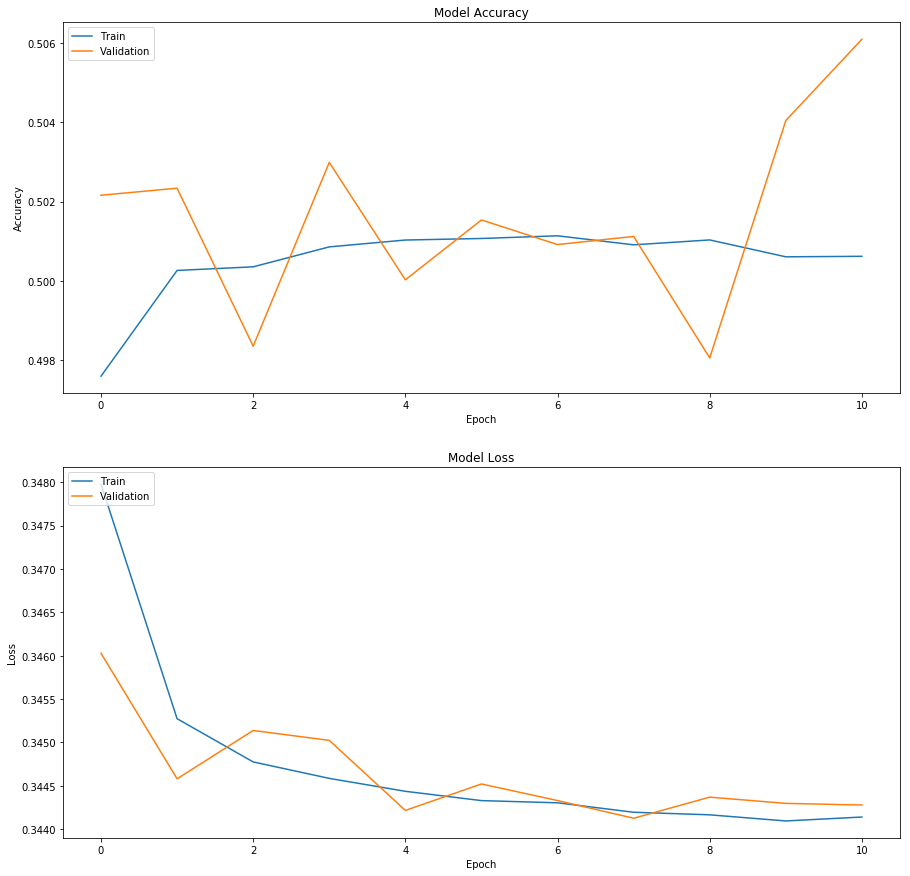

In [143]:
train_hist_plot(finalXXII_history, "model_finalXXII_train_perf")

In [144]:
model_finalXXII_stats = model_metrics(model_finalXXII, 'model_finalXXII', finalXXII_history, X_test_scaled, y_test)

In [145]:
model_metrics_df = model_metrics_df.append(model_finalXXII_stats, ignore_index=True)

## Model 23

In [146]:
# Instatiate a Sequential model
model_finalXXIII = Sequential()

# Create a basic network
model_finalXXIII.add(Dense(25, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_finalXXIII.add(Dense(25, activation = 'tanh'))
model_finalXXIII.add(Dense(25, activation = 'tanh'))
model_finalXXIII.add(Dense(25, activation = 'relu'))
model_finalXXIII.add(Dense(25, activation = 'relu'))
model_finalXXIII.add(Dense(25, activation = 'relu'))
model_finalXXIII.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXXIII.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [147]:
finalXXIII_checkpoint_path, finalXXIII_history = fit_save_model(model_finalXXIII, 'model_finalXXIII', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 80s 67us/step - loss: 0.3488 - categorical_accuracy: 0.4961 - val_loss: 0.3456 - val_categorical_accuracy: 0.5026

Epoch 00001: val_loss improved from inf to 0.34556, saving model to model_final/model_finalXXIII.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 85s 71us/step - loss: 0.3456 - categorical_accuracy: 0.4995 - val_loss: 0.3457 - val_categorical_accuracy: 0.5002

Epoch 00002: val_loss did not improve from 0.34556
Epoch 3/50
1197789/1197789 [==============================] - 82s 68us/step - loss: 0.3451 - categorical_accuracy: 0.4997 - val_loss: 0.3449 - val_categorical_accuracy: 0.4986

Epoch 00003: val_loss improved from 0.34556 to 0.34491, saving model to model_final/model_finalXXIII.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 82s 69us/step - loss: 0.3449 - categorical_accuracy: 0.4995 - val_loss: 0.3447 - val_categorica

In [148]:
# Load best model to save training time
model_finalXXIII = keras.models.load_model('model_final/model_finalXXIII.hdf5')

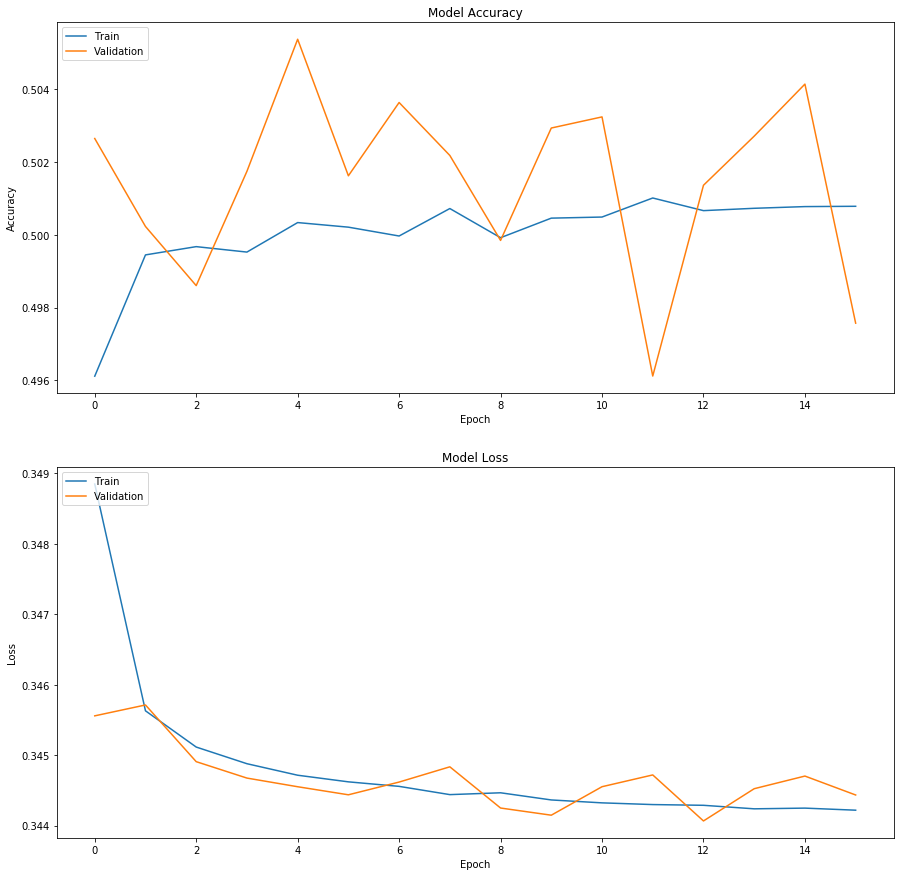

In [149]:
train_hist_plot(finalXXIII_history, "model_finalXXIII_train_perf")

In [150]:
model_finalXXIII_stats = model_metrics(model_finalXXIII, 'model_finalXXIII', finalXXIII_history, X_test_scaled, y_test)

In [151]:
model_metrics_df = model_metrics_df.append(model_finalXXIII_stats, ignore_index=True)

## Model 24

In [152]:
# Instatiate a Sequential model
model_finalXXIV = Sequential()

# Create a basic network
model_finalXXIV.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_finalXXIV.add(Dense(25, activation = 'elu'))
model_finalXXIV.add(Dense(25, activation = 'elu'))
model_finalXXIV.add(Dense(25, activation = 'elu'))
model_finalXXIV.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXXIV.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [153]:
finalXXIV_checkpoint_path, finalXXIV_history = fit_save_model(model_finalXXIV, 'model_finalXXIV', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 79s 66us/step - loss: 0.3478 - categorical_accuracy: 0.4976 - val_loss: 0.3451 - val_categorical_accuracy: 0.5030

Epoch 00001: val_loss improved from inf to 0.34514, saving model to model_final/model_finalXXIV.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 72s 60us/step - loss: 0.3450 - categorical_accuracy: 0.5002 - val_loss: 0.3444 - val_categorical_accuracy: 0.5037

Epoch 00002: val_loss improved from 0.34514 to 0.34441, saving model to model_final/model_finalXXIV.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 72s 61us/step - loss: 0.3446 - categorical_accuracy: 0.5006 - val_loss: 0.3445 - val_categorical_accuracy: 0.5032

Epoch 00003: val_loss did not improve from 0.34441
Epoch 4/50
1197789/1197789 [==============================] - 74s 62us/step - loss: 0.3443 - categorical_accuracy: 0.5008 - val_loss: 0.3442 - val_categorical_

In [154]:
# Load best model to save training time
model_finalXXIV = keras.models.load_model('model_final/model_finalXXIV.hdf5')

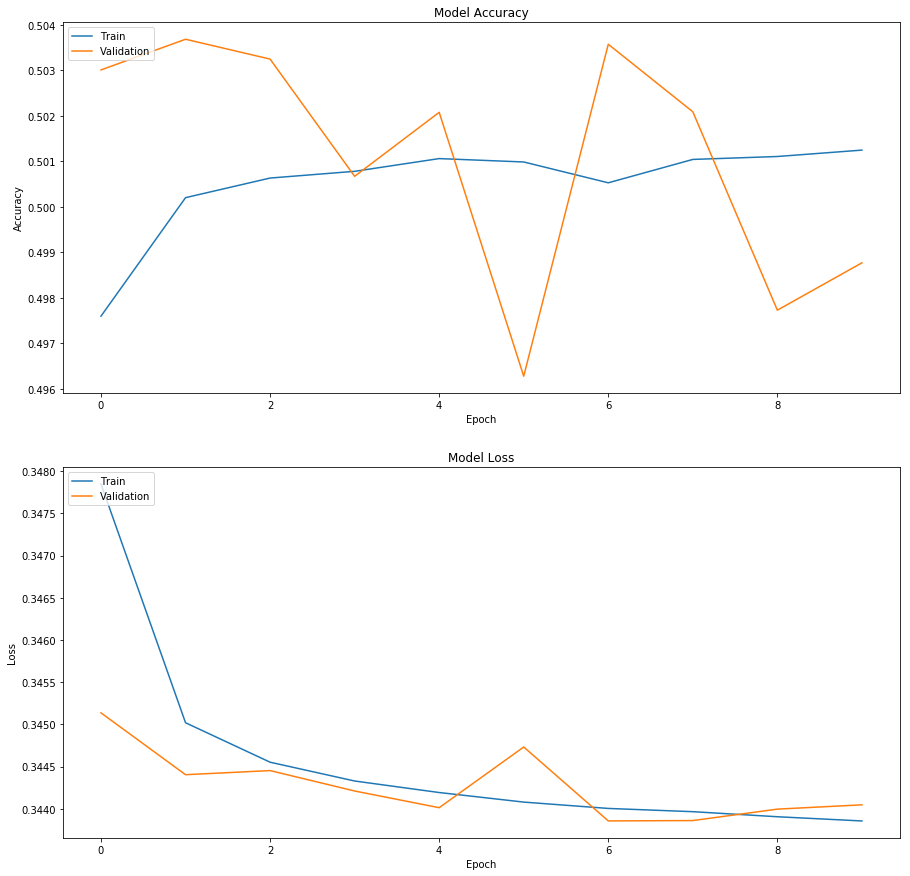

In [155]:
train_hist_plot(finalXXIV_history, "model_finalXXIV_train_perf")

In [156]:
model_finalXXIV_stats = model_metrics(model_finalXXIV, 'model_finalXXIV', finalXXIV_history, X_test_scaled, y_test)

In [157]:
model_metrics_df = model_metrics_df.append(model_finalXXIV_stats, ignore_index=True)

## Model 25

In [158]:
# Instatiate a Sequential model
model_finalXXV = Sequential()

# Create a basic network
model_finalXXV.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_finalXXV.add(Dense(25, activation = 'elu'))
model_finalXXV.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalXXV.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [159]:
finalXXV_checkpoint_path, finalXXV_history = fit_save_model(model_finalXXV, 'model_finalXXV', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/50
1197789/1197789 [==============================] - 72s 60us/step - loss: 0.3482 - categorical_accuracy: 0.4980 - val_loss: 0.3449 - val_categorical_accuracy: 0.5023

Epoch 00001: val_loss improved from inf to 0.34490, saving model to model_final/model_finalXXV.hdf5
Epoch 2/50
1197789/1197789 [==============================] - 73s 61us/step - loss: 0.3450 - categorical_accuracy: 0.5004 - val_loss: 0.3448 - val_categorical_accuracy: 0.4973

Epoch 00002: val_loss improved from 0.34490 to 0.34476, saving model to model_final/model_finalXXV.hdf5
Epoch 3/50
1197789/1197789 [==============================] - 66s 55us/step - loss: 0.3444 - categorical_accuracy: 0.5005 - val_loss: 0.3442 - val_categorical_accuracy: 0.5000

Epoch 00003: val_loss improved from 0.34476 to 0.34417, saving model to model_final/model_finalXXV.hdf5
Epoch 4/50
1197789/1197789 [==============================] - 59s 49us/step - loss: 0.3442 - categorical_acc

In [160]:
# Load best model to save training time
model_finalXXV = keras.models.load_model('model_final/model_finalXXV.hdf5')

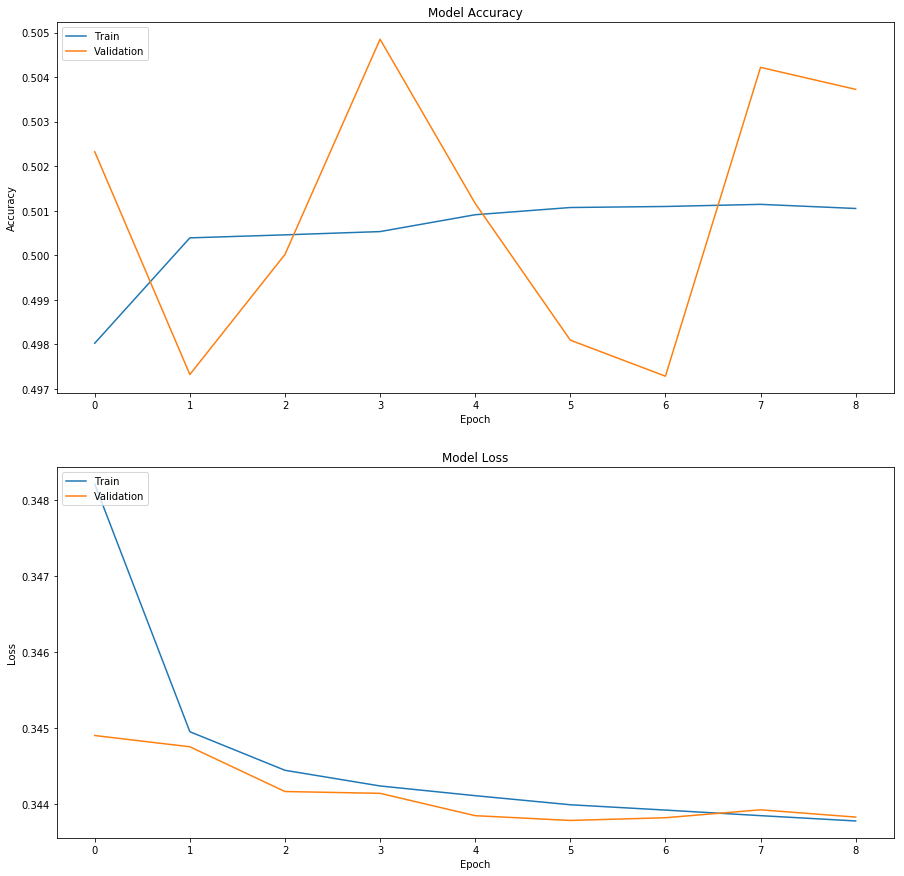

In [161]:
train_hist_plot(finalXXV_history, "model_finalXXV_train_perf")

In [162]:
model_finalXXV_stats = model_metrics(model_finalXXV, 'model_finalXXV', finalXXV_history, X_test_scaled, y_test)

In [163]:
model_metrics_df = model_metrics_df.append(model_finalXXV_stats, ignore_index=True)

# Model Metrics

In [164]:
model_metrics_df

,model_name,val_loss,AUC,hamming_loss,call_B_precision,call_B_recall,call_B_fscore,call_C_precision,call_C_recall,call_C_fscore,...,call_F_fscore,call_H_precision,call_H_recall,call_H_fscore,call_S_precision,call_S_recall,call_S_fscore,is_out_precision,is_out_recall,is_out_fscore
0,model_final_base,0.344275,0.691669,0.232475,0.681104,0.847802,0.755365,0.422605,0.748996,0.540337,...,0.407623,0.122568,0.703704,0.208772,0.290498,0.147526,0.195678,0.404278,0.527555,0.457762
1,model_final2,0.344092,0.688450,0.230156,0.683123,0.846524,0.756096,0.419016,0.759525,0.540080,...,0.400196,0.121432,0.713453,0.207540,0.302742,0.101368,0.151881,0.406131,0.528290,0.459226
2,model_final3,0.344371,0.692491,0.233677,0.658105,0.864889,0.747459,0.416540,0.766708,0.539810,...,0.396821,0.122637,0.689152,0.208221,0.264752,0.239317,0.251393,0.413344,0.512842,0.457749
3,model_final4,0.344446,0.690665,0.228579,0.673846,0.853185,0.752984,0.414562,0.768103,0.538490,...,0.400946,0.125773,0.669009,0.211739,0.286568,0.160332,0.205621,0.405532,0.528853,0.459054
4,model_final5,0.344471,0.691637,0.231263,0.666081,0.859845,0.750661,0.427818,0.731976,0.540014,...,0.407758,0.125970,0.669946,0.212065,0.282562,0.171138,0.213167,0.399784,0.541846,0.460099
5,model_final6,0.344514,0.689458,0.230567,0.669222,0.856179,0.751243,0.432555,0.717777,0.539806,...,0.399987,0.122499,0.697175,0.208384,0.283811,0.164169,0.208013,0.397707,0.544886,0.459806
6,model_final7,0.343863,0.693042,0.235583,0.669089,0.857723,0.751753,0.427544,0.734797,0.540561,...,0.404347,0.121857,0.715825,0.208262,0.279329,0.178500,0.217811,0.395932,0.556851,0.462803
7,model_final8,0.343735,0.687557,0.222939,0.674753,0.852194,0.753163,0.427562,0.735500,0.540765,...,0.397052,0.127804,0.651910,0.213711,0.297616,0.127111,0.178139,0.398229,0.547255,0.460997
8,model_final9,0.343708,0.692418,0.235895,0.658127,0.865395,0.747662,0.420112,0.756826,0.540303,...,0.398707,0.120994,0.723144,0.207303,0.279223,0.188633,0.225158,0.398724,0.548802,0.461877
9,model_finalX,0.344258,0.689549,0.229025,0.673548,0.853612,0.752965,0.431199,0.724313,0.540579,...,0.408088,0.124799,0.680867,0.210934,0.291407,0.145460,0.194054,0.414616,0.506870,0.456125


In [165]:
model_metrics_df.to_csv('model_metrics.csv')